# Modeling

In [201]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
%matplotlib inline

In [206]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.sample(20)

TM_A                  TM_B  target
117             CAMBRIDGE   CAMBRIDGE NeuroTech       1
5                Flossies             Flossbone       1
130              Snakeman           Snake Brand       1
332        WOOLLY AND TIG          WOOZLE & PIP       0
191                    AE                    EE       1
346                    GO             SHELL GO+       0
303                   CME             IRSIA CMF       0
39                    VPR                  Vpro       1
228              PACIFICO               PACIFIC       1
225              Vapouriz             Vaporized       1
242            THE HOBBIT  GIRAFFE & HOBBIT LTD       1
8        Frickin’ Chicken        Flip’n Chicken       1
289  THE HYDE PARK DY GIN      HYDE PARK CORNER       0
32                   Wolf             Dr. Wolff       1
91               Easypack              Easipack       1
241                UKWAGO                  WAGO       1
167                  LOCO                  LOKA       1
321              StoneRez              STONCARE       0
118               GREYBOX                  GREY       1
106           SOHO GARDEN            SOHO HOUSE       1

In [207]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [208]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [209]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [210]:
from abydos.phones import *

In [211]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [212]:
import re

In [213]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [214]:


# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

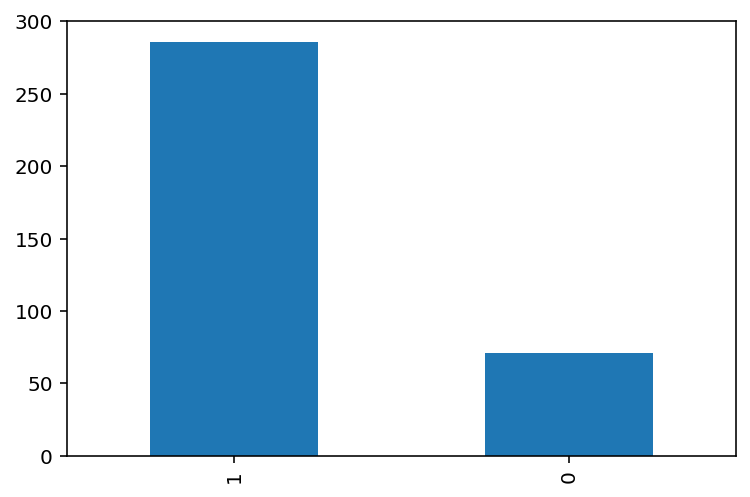

In [215]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [216]:
from itertools import combinations
import random
random.seed(42)


In [300]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=350), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

TM_A                     TM_B
0                 MICRONCLEAN                    MEDAX
1                        LOKA                       AE
2    THE REAL PETFOOD COMPANY                      FIS
3                       DENIM               HELLO DIET
4                       VEYPE                   Kresco
..                        ...                      ...
345                     AMCAP          SEARCH SAVVY PR
346                       HCP             Canvas Homes
347                   JETBLUE  Nature Research Society
348        Fashion two twenty                  UBERJET
349                ROOM SEVEN               Dank Vapes

[350 rows x 2 columns]

In [301]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:1


In [302]:
nonmatch_cases.sample(20)

TM_A                     TM_B
257               UKWAGO                    Stoke
302   Fashion two twenty            TOAST IT NOTE
299    GREEN BRITISH GAS                      FIS
93   Smartworking Summit  THE POWER OF SIMPLICITY
338                 Kozo                     Zero
152                GENIE        Dylan Corner Sofa
162               Britsa              MICRONCLEAN
186                HORSE                      T2A
322               Seycos                Flossbone
178                   BE                RedInside
187              Pinkies                    TIAMA
165                UWELL                   VESPER
49          TLC Training                       T2
104               Pledge               HELLO DIET
309           PROVENTURE                Eden Pure
64             OPTORONIC              London Resi
218              TLCLIVE                  Potters
21          Canvas Homes        HAMILTON & INCHES
61           THEUNIBIBLE                 WOODLAND
69             DERMAWELL                    CELIO

In [303]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

class_balanced

# class_balanced[class_balanced['TM_B'].str.len()!=0]


TM_A                 TM_B  target
0            Simoniz            Permanize       1
1           Magnavoc             Multivox       1
2              Zirco               Cozirc       1
3      Platinum Puff        Platinum Plus       1
4    Maternity Yours  Your Maternity Shop       1
..               ...                  ...     ...
352           Lilton               Wilton       0
353         Nutricia             Nutritea       0
354        Glenreidh            An Reidhe       0
355  No Gunk No Junk    No Gunk Just Funk       0
356         e-Relief         LIGHT RELIEF       0

[707 rows x 3 columns]

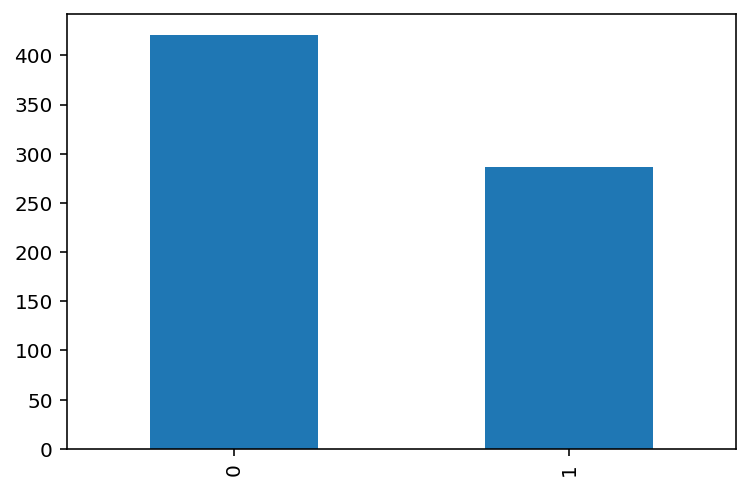

In [304]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [305]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


a                           b  target          TM_A  \
327          DWELL                         TSS       0         dwell   
177           KOTO                        Kozo       1          koto   
17           Point                       Poynt       1         point   
335            GSR                        GSRD       0           gsr   
1         Magnavoc                    Multivox       1      magnavoc   
128         DIALux                        DIAL       1        dialux   
183  Fizz Fitness                     Fizz Bug       1   fizzfitness   
96    TRUETRAVELER                         AEG       0  truetraveler   
220      Artigiano          Espresso Artigiano       1     artigiano   
168           VYPE  WILD AND WOOD COFFEE HOUSE       0          vype   
278           PAPA                  PaPa Spice       1          papa   
24      MONSTAVAPE                        Snow       0    monstavape   
70           PONIM                       CELIO       0         ponim   
190            SKY                     SKYCLAD       1           sky   
312          MEDAC              MONSTER ENERGY       0         medac   
153  Xtreme Lashes               Xtreme Makeup       1  xtremelashes   
129           MONT                   Mont Noir       1          mont   
111           FLYE                         IBM       0          flye   
335     WELLBLOCKS                        GREY       0    wellblocks   
210            AEG                   AEG Group       1           aeg   

                       TM_B  partial  tkn_sort  tkn_set   sum_ipa  \
327                     tss        0         0        0  0.306452   
177                    kozo       75        75       75  0.975806   
17                    poynt       80        80       80  1.000000   
335                    gsrd      100        86       86  1.000000   
1                  multivox       38        38       38  0.691532   
128                    dial      100        80       80  0.571429   
183                 fizzbug       57        44       44  0.690323   
96                      aeg       67        27       27  0.217009   
220       espressoartigiano      100        69       69  0.717742   
168  wildandwoodcoffeehouse       25         8        8  0.697581   
278               papaspice      100        62       62  1.000000   
24                     snow       25        14       14  0.238351   
70                    celio       20        20       20  0.822581   
190                 skyclad      100        60       60  1.000000   
312           monsterenergy       20        22       22  0.812903   
153            xtrememakeup       67        67       67  0.896505   
129                montnoir      100        67       67  1.000000   
111                     ibm        0         0        0  0.400000   
335                    grey        0        14       14  0.270609   
210                aeggroup      100        55       55  1.000000   

     levenshtein  metaphone  nysiis  mtch_rtng_cdx  pshp_soundex_first  \
327     0.151515          0       0              0                   0   
177     0.030303          0       0              0                   0   
17      0.030303          1       0              0                   1   
335     0.030303          0       0              0                   0   
1       0.151515          0       0              0                   0   
128     0.060606          0       0              0                   1   
183     0.212121          0       0              0                   1   
96      0.303030          0       0              0                   0   
220     0.242424          0       0              0                   0   
168     0.636364          0       0              0                   0   
278     0.151515          0       0              0                   1   
24      0.272727          0       0              0                   0   
70      0.121212          0       0              0                   0   
190     0.121212  

#### Export clean data to csv

In [306]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [307]:
y = df.target
X = df.drop(columns = 'target')

In [308]:
from sklearn.model_selection import train_test_split

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [310]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [311]:
from tpot import TPOTClassifier

In [312]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [313]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [314]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [315]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

target  partial  tkn_sort  tkn_set   sum_ipa  levenshtein  metaphone  \
0         1       57        50       50  0.658986     0.151515          0   
1         1       38        38       38  0.691532     0.151515          0   
2         1       89        73       73  0.806452     0.090909          0   
3         1       83        83       83  0.895161     0.090909          0   
4         1       74        65       65  0.743176     0.272727          0   
..      ...      ...       ...      ...       ...          ...        ...   
352       0       83        83       83  0.943548     0.030303          0   
353       0       75        75       75  0.874552     0.060606          0   
354       0       80        71       71  0.498208     0.121212          0   
355       0       67        77       77  0.822581     0.151515          0   
356       0       86        67       67  0.629032     0.151515          0   

     nysiis  mtch_rtng_cdx  pshp_soundex_first  iterativesubstring     bisim  \
0         0              0                   0            0.485480  0.388889   
1         0              0                   0            0.050000  0.437500   
2         0              0                   0            0.821263  0.583333   
3         0              0                   1            0.884677  0.833333   
4         0              0                   0            0.951613  0.588235   
..      ...            ...                 ...                 ...       ...   
352       0              0                   0            0.897436  0.750000   
353       0              0                   1            0.804167  0.750000   
354       0              0                   0            0.800858  0.611111   
355       0              0                   1            0.852383  0.678571   
356       0              0                   0            0.793397  0.500000   

     discountedlevenshtein  prefix    lcsstr  mlipns  strcmp95       mra  \
0                 0.383752   0.000  0.333333     0.0  0.722751  0.666667   
1                 0.366778   0.125  0.250000     0.0  0.633333  0.500000   
2                 0.495199   0.000  0.666667     0.0  0.822222  0.833333   
3                 0.818487   0.750  0.750000     1.0  0.933333  0.500000   
4                 0.472052   0.000  0.529412     0.0  0.700700  0.000000   
..                     ...     ...       ...     ...       ...       ...   
352               0.796089   0.000  0.833333     1.0  0.822222  0.833333   
353               0.798406   0.625  0.625000     1.0  0.915000  0.833333   
354               0.510437   0.000  0.666667     0.0  0.741402  0.666667   
355               0.700763   0.500  0.428571     0.0  0.898810  0.833333   
356               0.479055   0.000  0.545455     0.0  0.713131  0.500000   

       editex      saps  flexmetric      jaro  higueramico     sift4  \
0    0.555556  0.137931    0.566667  0.671958     0.430556  0.444444   
1    0.500000  0.304348    0.400000  0.583333     0.375000  0.375000   
2    0.500000  0.428571    0.600000  0.822222     0.547619  0.666667   
3    0.833333  0.666667    0.833333  0.888889     0.769231  0.833333   
4    0.588235  0.319149    0.538235  0.687675     0.490372  0.588235   
..        ...       ...         ...       ...          ...       ...   
352  0.833333  0.500000    0.833333  0.822222     0.833333  0.833333   
353  0.812500  0.565217    0.787500  0.833333     0.750000  0.750000   
354  0.666667  0.310345    0.666667  0.741402     0.588889  0.666667   
355  0.678571  0.469388    0.700000  0.815873     0.637363  0.714286   
356  0.636364  0.166667    0.663636  0.689755     0.482071  0.363636   

        eudex     aline  phoneticeditdistance  
0    0.654902  0.602128              0.727599  
1    0.916667  0.545455              0.897177  
2    0.786275  0.705882              0.634409  
3    1.000000  0.873529              0.913978  
4    0.463725  0.589655              0.646110  
..        ...       ...                   ...  
352  

In [316]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3, 
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0])

In [317]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [318]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.15211335106959575,
 0.6775273307929539,
 0.6725639997967685,
 0.6590601952100241,
 0.15313430433197084,
 0.4605944666661349,
 0.6094230197043186,
 0.15211335106959575,
 0.15211335106959575,
 0.6714548911996244,
 0.6500262517711555,
 0.6335638700219602,
 0.153558245994704,
 0.6307666096210047,
 0.6341667041590349,
 0.7064810476612473,
 0.6647665604841394,
 0.15211335106959575,
 0.6590739344044095,
 0.6863494391834611,
 0.7226046500180564,
 0.5900321329064669,
 0.15211335106959575,
 0.15211335106959575,
 0.7103447683263951,
 0.6293851128711081,
 0.2150577594273471,
 0.6306513633875562,
 0.6471160631121422,
 0.5675040031403242,
 0.608823028330272,
 0.16442576433806,
 0.15211335106959575,
 0.15211335106959575,
 0.15211335106959575,
 0.15211335106959575,
 0.15637920247241435,
 0.6656064748313694,
 0.23607615516716352,
 0.5690238413187616,
 0.6157378675541627,
 0.15211335106959575,
 0.15211335106959575,
 0.16344029452010997,
 0.6171005133820293,
 0.15211335106959575,
 0.5722568536079298,


## K-fold cross validation

In [319]:
from sklearn.model_selection import StratifiedKFold

In [320]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
    
#     oof_pred['predict_probXGB'] = base_model_2(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
#                                       y_train,
#                                       X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

#     oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
#                                       y_train,
#                                       X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


In [321]:
meta_training.sample(20)

TM_A                         TM_B  \
298                     bridgestone                          fis   
44                        reddragon                       dragon   
342                      cristaline  krystalnaturesalkalinewater   
56                           vapeco                      pacific   
91                       britishgas                  toastitnote   
294  intercontecinfiniteconnections        interconnectsolutions   
264                         circuit                          tss   
59                             zero                    sugarzero   
128                         silarom                   charterhcp   
336                     astonmartin                    astonhill   
241                           frill                  toastitnote   
33                           rawkus                    gideonsuk   
275                           milan                  milansweets   
161                         theqube           gazianteppastanesi   
196                          simtec                willowtreegin   
141                          bodrum                        didim   
321                      connectcom                      vespers   
273                         halcyon                halcyoneffect   
153                    xtremelashes                 xtrememakeup   
72   poppositiveorganisationspeople                        verve   

     predict_proba  target  
298       0.164982       0  
44        0.658252       1  
342       0.486805       0  
56        0.160441       0  
91        0.155439       0  
294       0.671548       0  
264       0.165742       0  
59        0.667029       1  
128       0.155893       0  
336       0.570194       0  
241       0.153900       0  
33        0.159060       0  
275       0.730964       1  
161       0.156953       0  
196       0.168210       0  
141       0.186752       1  
321       0.154677       0  
273       0.742778       1  
153       0.648351       1  
72        0.195406       0

### Meta-Model: Logistic Regression

In [322]:
df=featurize(meta_training)

In [323]:
df.sample(20)

a                b  predict_proba  target  \
187                    pinkies            tiama       0.153900       0   
31                        flye            gusto       0.158929       0   
120               gameofstones    gameofthrones       0.683880       1   
233                    skyrizi               ta       0.176161       0   
350                purpleforce   purpleaccounts       0.575248       0   
146                        fwd          fwdview       0.720373       1   
132  totalmotionaffinityscheme  affinityleasing       0.590240       1   
186                      horse               ta       0.155453       0   
256                     candey     xtrememakeup       0.156013       0   
4                        veype           kresco       0.156826       0   
293                   eezeevet   easipetcareltd       0.230021       0   
304                  lifestyle        dankvapes       0.156042       0   
33                       sabis            sabis       0.644617       1   
295                deadlydenim            anker       0.153900       0   
286                 whitespace         percipio       0.154677       0   
124                 diamondpay         transics       0.153900       0   
55                         rad             rads       0.644394       1   
37                     soupdup          emolite       0.153900       0   
19                platinumpuff      micronclean       0.156013       0   
345                      amcap    searchsavvypr       0.200768       0   

                          TM_A             TM_B  partial  tkn_sort  tkn_set  \
187                    pinkies            tiama       20        17       17   
31                        flye            gusto        0         0        0   
120               gameofstones    gameofthrones       83        88       88   
233                    skyrizi               ta        0         0        0   
350                purpleforce   purpleaccounts       64        56       56   
146                        fwd          fwdview      100        60       60   
132  totalmotionaffinityscheme  affinityleasing       62        45       45   
186                      horse               ta        0         0        0   
256                     candey     xtrememakeup       33        22       22   
4                        veype           kresco       20        18       18   
293                   eezeevet   easipetcareltd       38        36       36   
304                  lifestyle        dankvapes       22        22       22   
33                       sabis            sabis      100       100      100   
295                deadlydenim            anker       20        25       25   
286                 whitespace         percipio       25        22       22   
124                 diamondpay         transics       25        22       22   
55                         rad             rads      100        86       86   
37                     soupdup          emolite       14        14       14   
19                platinumpuff      micronclean       27        26       26   
345                      amcap    searchsavvypr       40        44       44   

      sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
187  0.491935     0.181818          0       0              0   
31   0.651613     0.151515          0       0              0   
120  0.988270     0.090909          0       0              0   
233  0.202765     0.212121          0       0              0   
350  0.811828     0.212121          0       0              0   
146  1.000000     0.121212          0       0              0   
132  0.396628     0.545455          0       0              0   
186  0.341935     0.151515          0       0              0   
256  0.833333     0.333333          0       0              0   
4    0.709677     0.151515          0       0              0   
293  0.967742     0.303030          0       0              0   
304  0.743728     0.272727          0       0 

### Evaluate Gradient Boosting Classifier

In [367]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[72 12]
 [ 6 52]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        84
           1       0.81      0.90      0.85        58

    accuracy                           0.87       142
   macro avg       0.87      0.88      0.87       142
weighted avg       0.88      0.87      0.87       142



In [325]:
# df_confusion.to_csv('TM_GBC_Confusion_matrix.csv')

In [326]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.946')

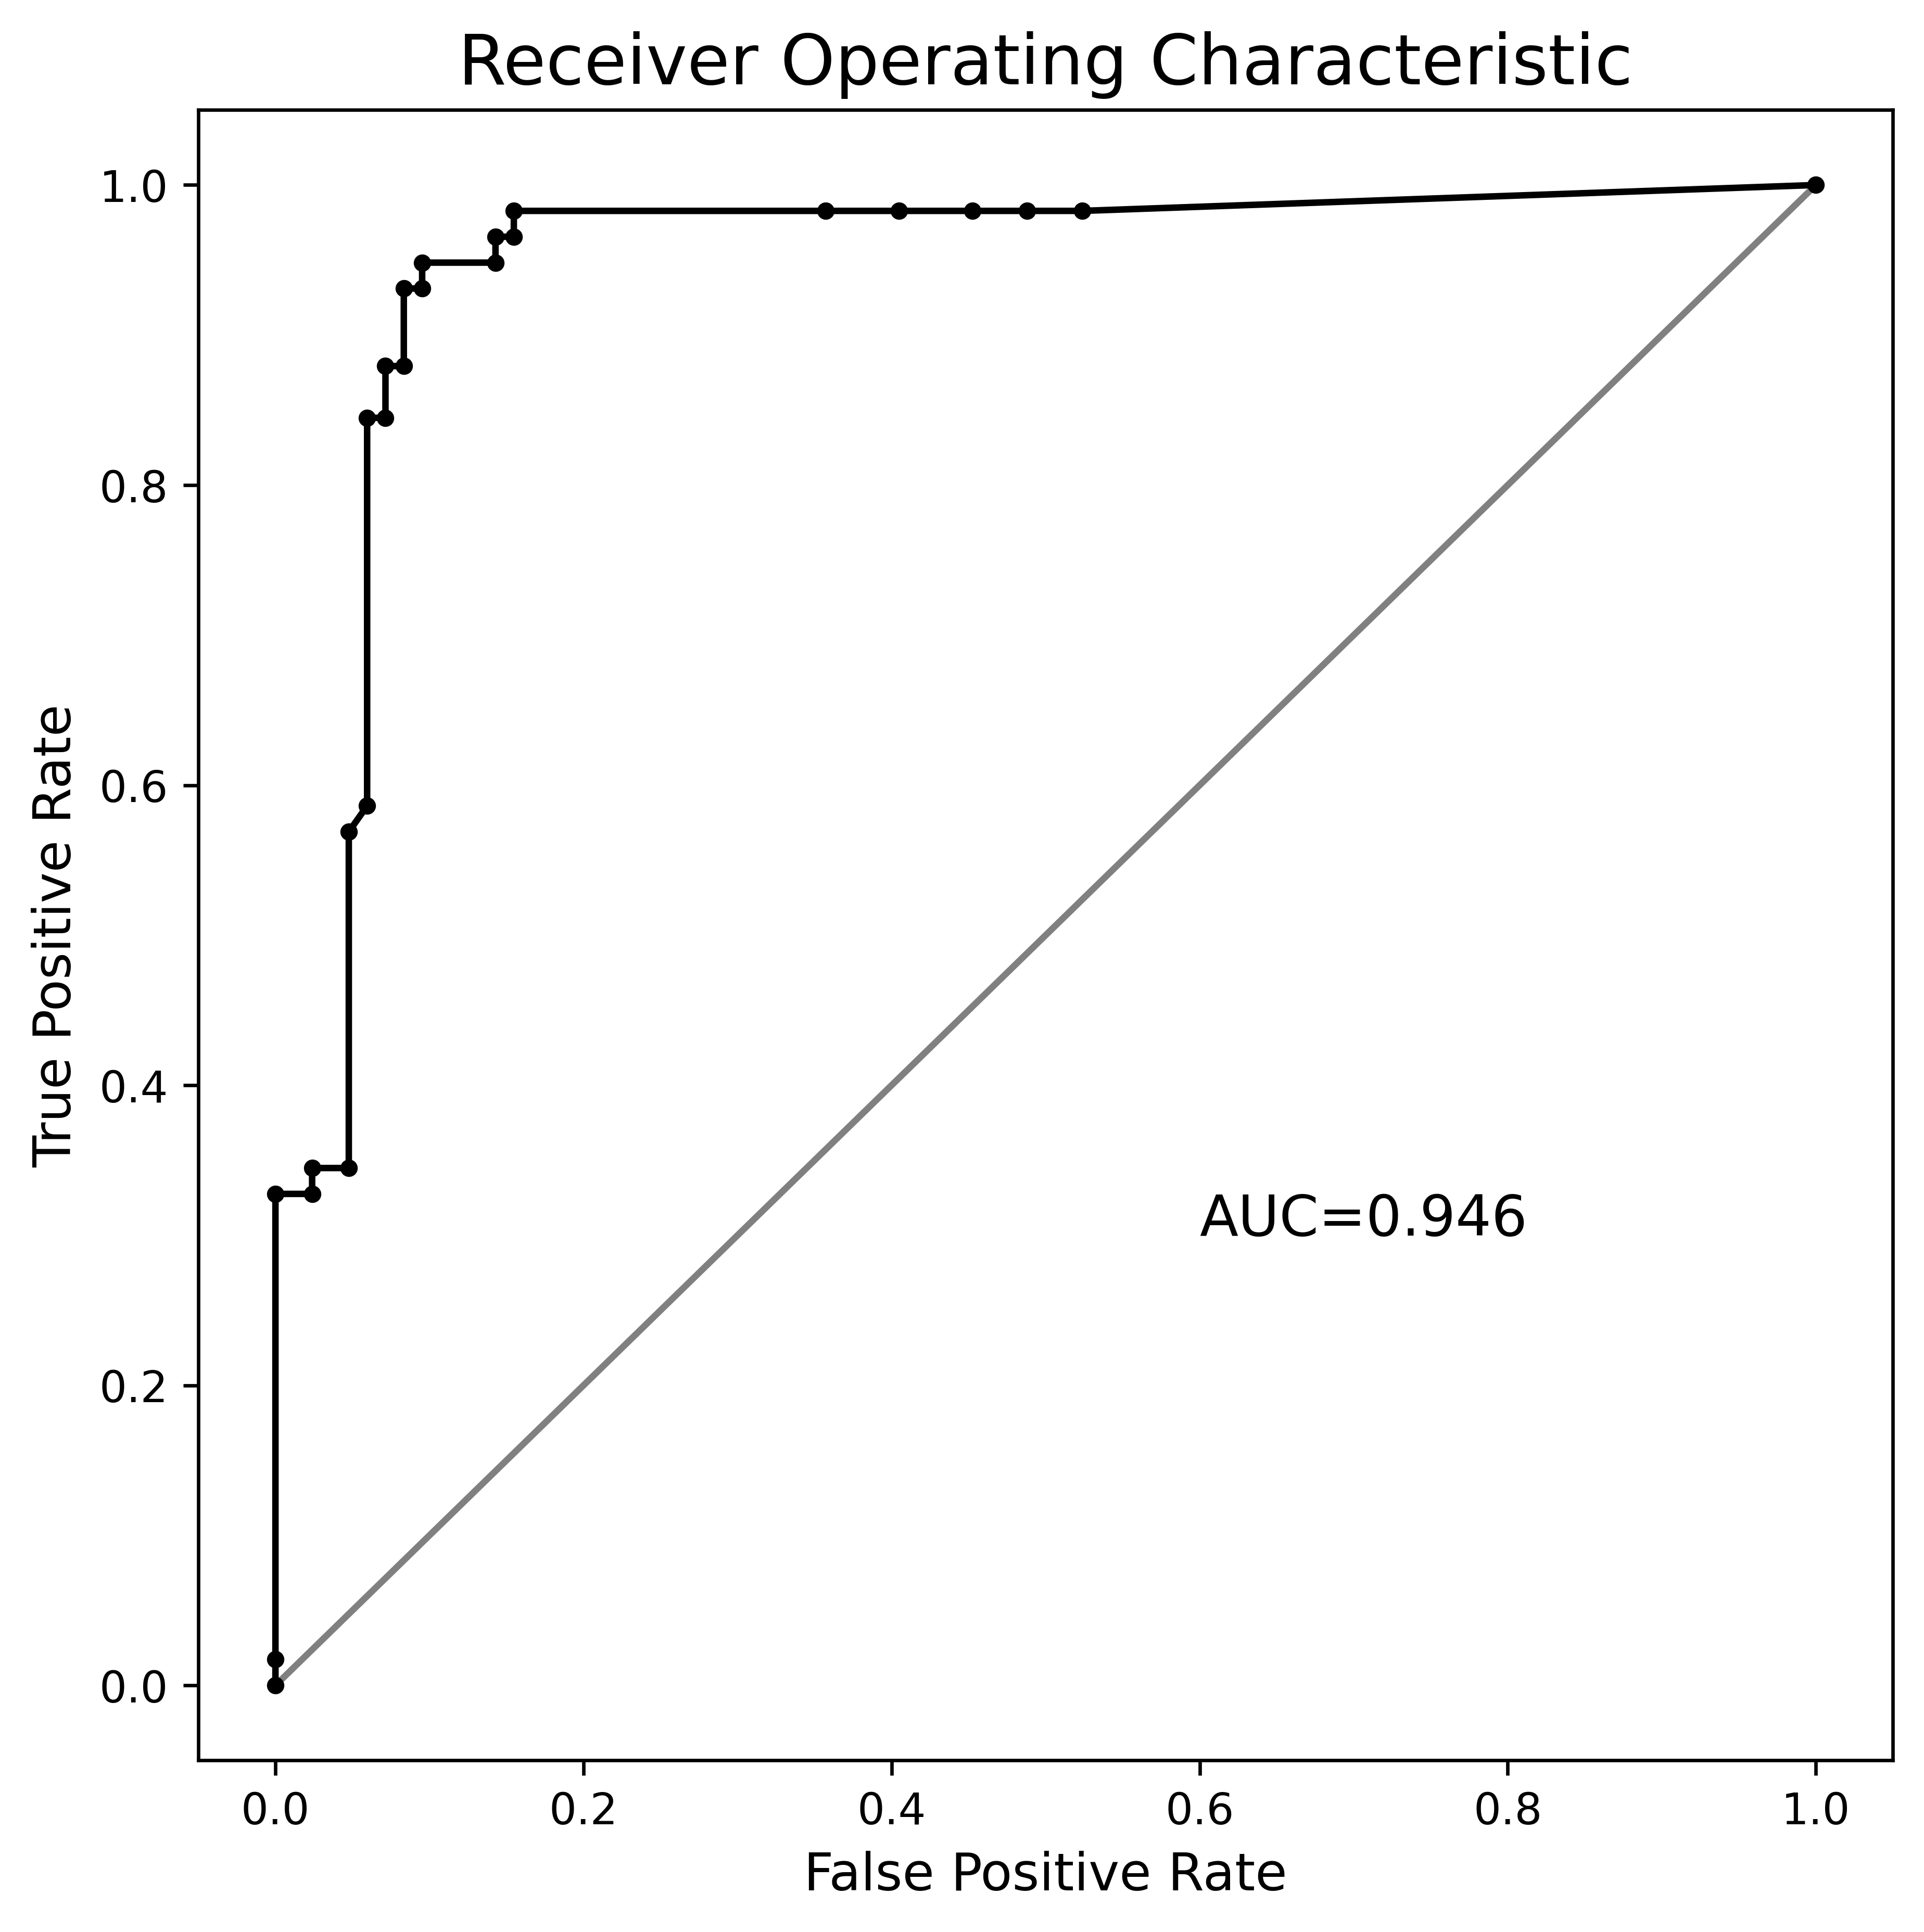

In [366]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

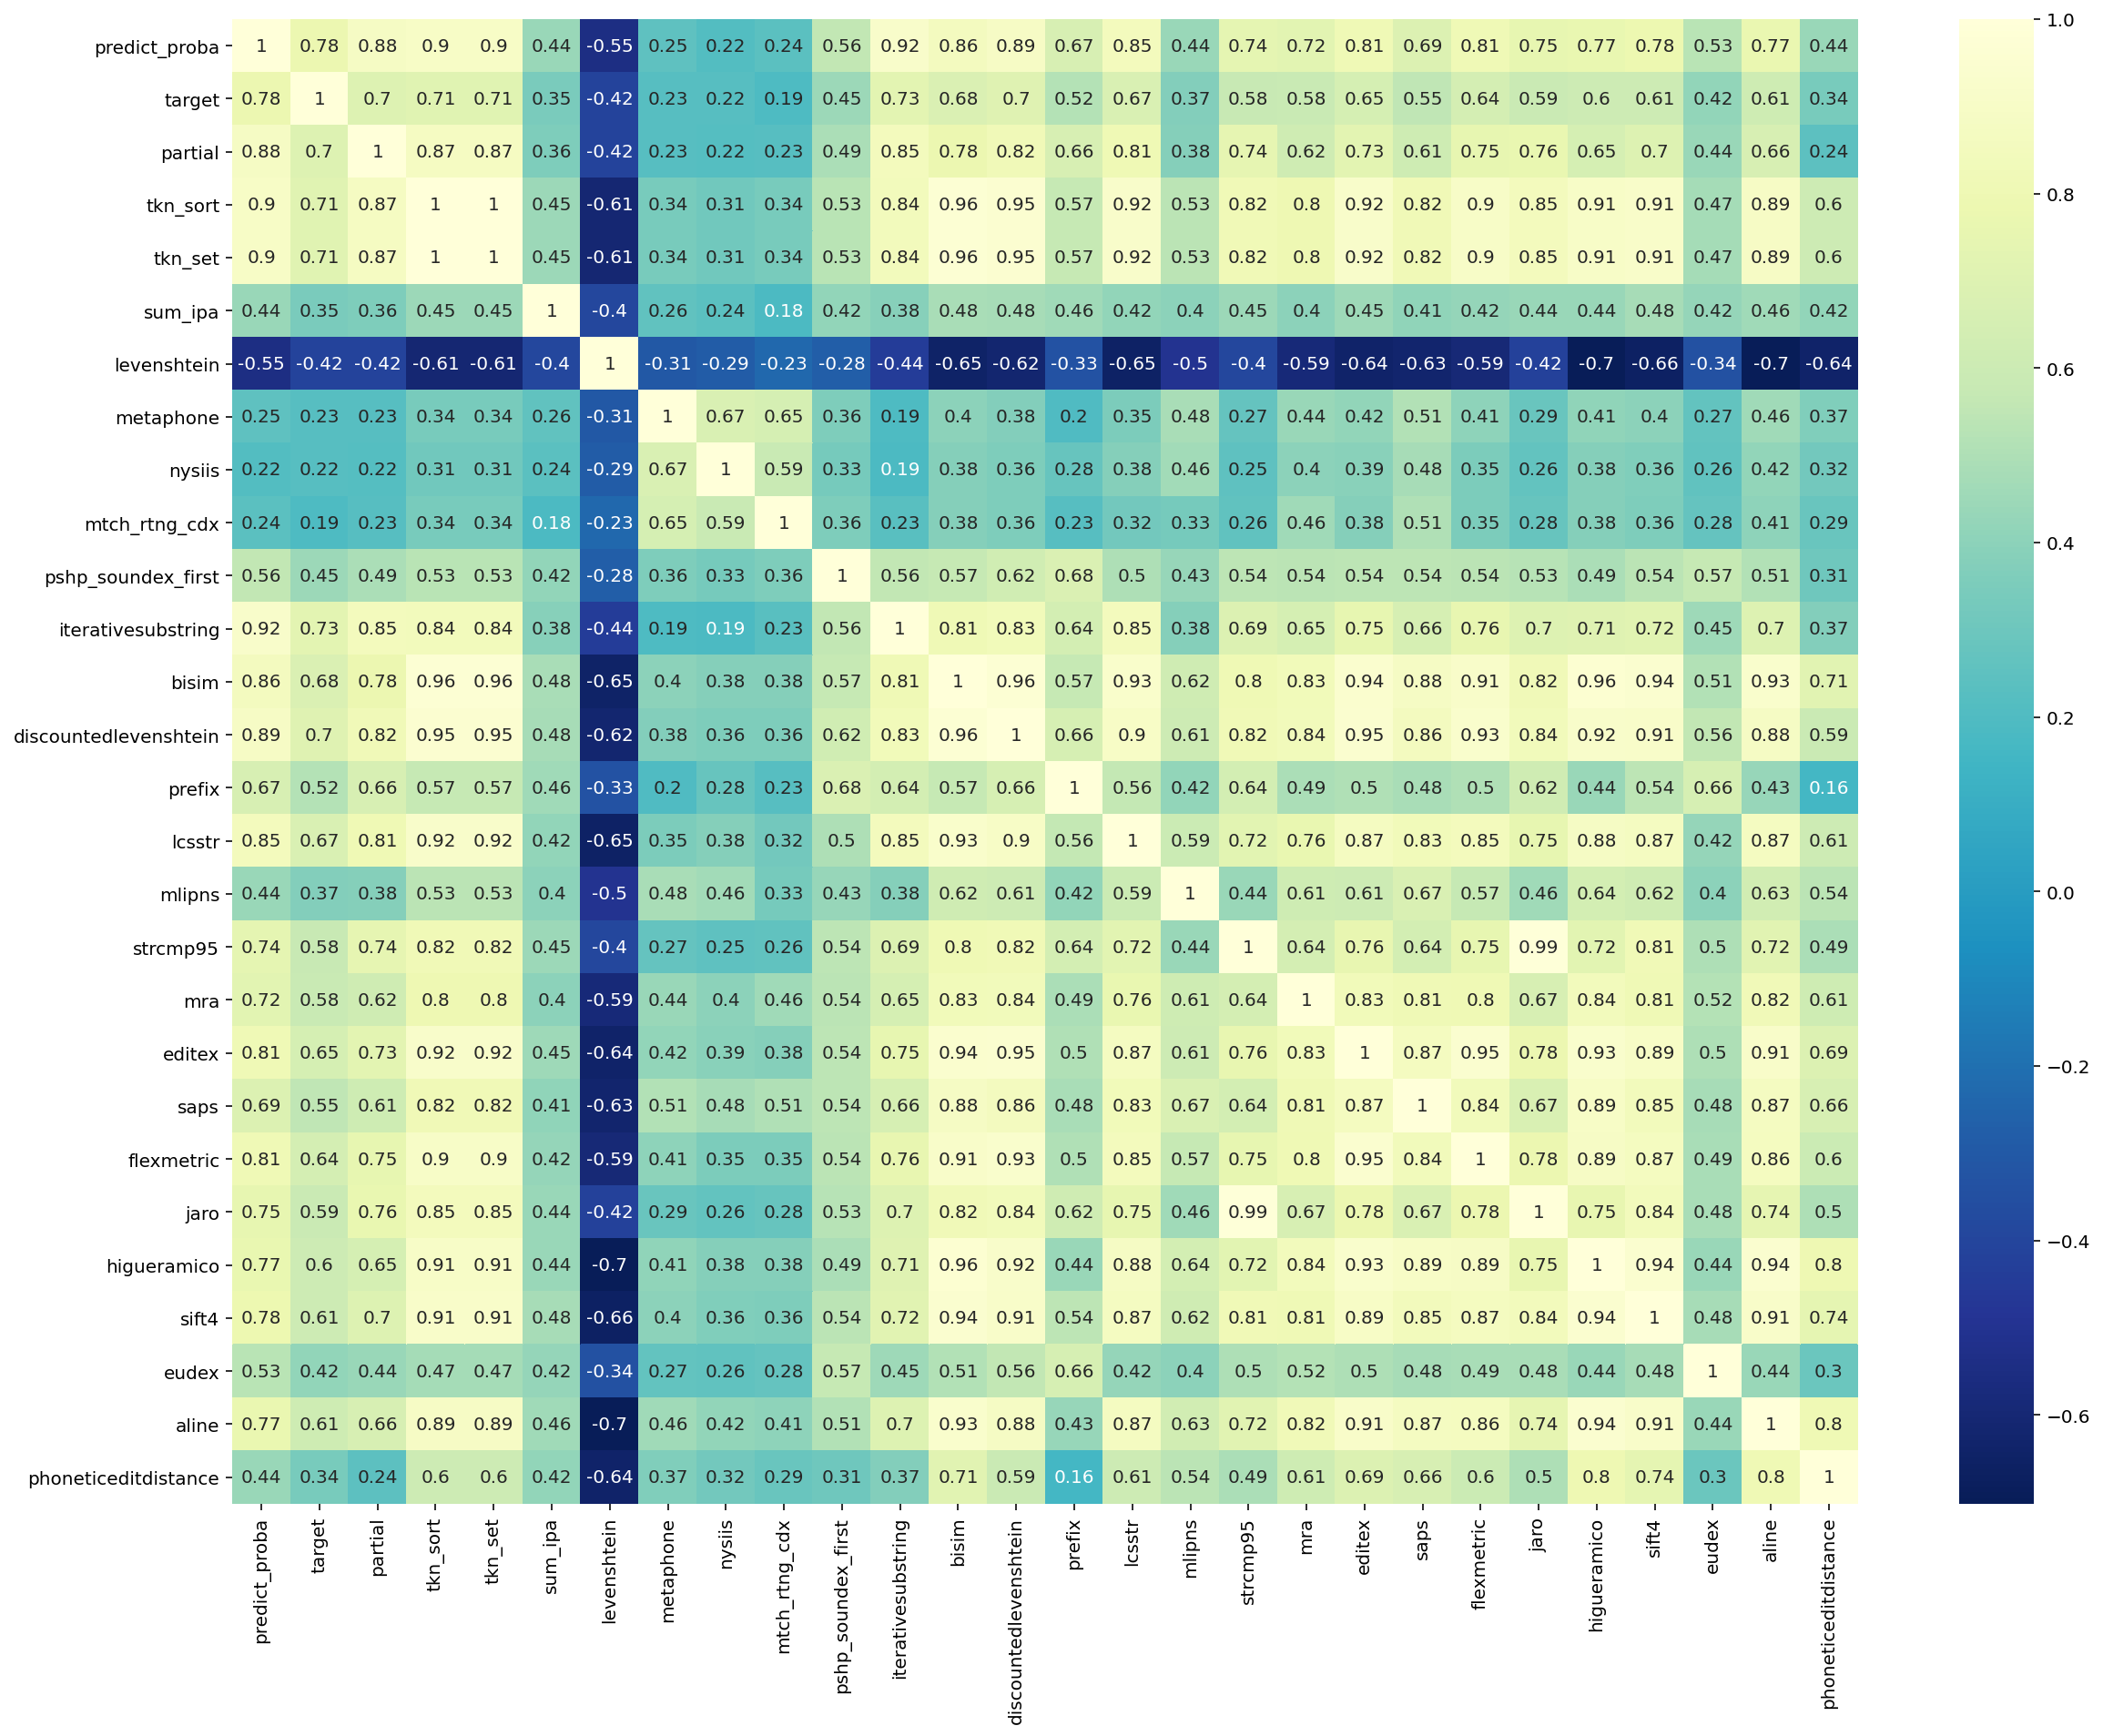

In [329]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [330]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(gb_clf2)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar")

AssertionError: Summary plots need a matrix of shap_values, not a vector.

# XGboost

In [343]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X

a             b            TM_A          TM_B  partial  \
2             zirco        cozirc           zirco        cozirc       89   
8    frickinchicken  flipnchicken  frickinchicken  flipnchicken       75   
12           kresco        cresco          kresco        cresco       83   
14        starbucks      sambucks       starbucks      sambucks       75   
45            zlide    logicslide           zlide    logicslide       80   
..              ...           ...             ...           ...      ...   
296          brexit     brexitbox          brexit     brexitbox      100   
300           rives        rivers           rives        rivers       80   
324        stonerez      stonkote        stonerez      stonkote       62   
335             gsr          gsrd             gsr          gsrd      100   
352          lilton        wilton          lilton        wilton       83   

     tkn_sort  tkn_set   sum_ipa  levenshtein  metaphone  nysiis  \
2          73       73  0.806452     0.090909          0       0   
8          77       77  0.666667     0.121212          0       0   
12         83       83  1.000000     0.030303          1       1   
14         82       82  0.891129     0.060606          0       0   
45         53       53  0.673387     0.181818          0       0   
..        ...      ...       ...          ...        ...     ...   
296        80       80  1.000000     0.090909          0       0   
300        91       91  0.967742     0.030303          0       0   
324        62       62  0.854839     0.121212          0       0   
335        86       86  1.000000     0.030303          0       0   
352        83       83  0.943548     0.030303          0       0   

     mtch_rtng_cdx  pshp_soundex_first  iterativesubstring     bisim  \
2                0                   0            0.821263  0.583333   
8                0                   0            0.742653  0.714286   
12               0                   1            0.897436  0.750000   
14               0                   0            0.717932  0.722222   
45               0                   0            0.697859  0.350000   
..             ...                 ...                 ...       ...   
296              0                   1            0.940000  0.666667   
300              0                   1            0.875809  0.750000   
324              0                   0            0.711111  0.625000   
335              0                   0            0.942857  0.750000   
352              0                   0            0.897436  0.750000   

     discountedlevenshtein    prefix    lcsstr  mlipns  strcmp95       mra  \
2                 0.495199  0.000000  0.666667     0.0  0.822222  0.833333   
8                 0.659416  0.083333  0.571429     0.0  0.832143  0.666667   
12                0.796089  0.000000  0.833333     1.0  0.922222  0.833333   
14                0.734595  0.125000  0.555556     0.0  0.895833  0.666667   
45                0.361280  0.000000  0.400000     0.0  0.593333  0.000000   
..                     ...       ...       ...     ...       ...       ...   
296               0.744506  1.000000  0.666667     1.0  0.933333  0.666667   
300               0.861286  0.800000  0.666667     1.0  0.966667  0.833333   
324               0.593675  0.500000  0.500000     0.0  0.865000  0.666667   
335               0.791811  1.000000  0.750000     1.0  0.941667  0.833333   
352               0.796089  0.000000  0.833333     1.0  0.822222  0.833333   

       editex      saps  flexmetric      jaro  higueramico     sift4  \
2    0.500000  0.428571    0.600000  0.822222     0.547619  0.666667   
8    0.785714  0.500000    0.757143  0.782540     0.708791  0.642857   
12   0.916667  0.619048    0.983333  0.888889     0.833333  0.833333   
14   0.777778  0.676471    0.844444  0.884259     0.777778  0.777778   
45   0.450000  0.085714    0.550000  0.533333     0.254365  0.200000   
..        ...       ...         ...       ...         

In [344]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

xgbmodel = xgb.train(param, D_train, steps)

In [345]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8752247752247753
Recall = 0.8854679802955665
Accuracy = 0.8802816901408451


In [346]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

### Evaluate XGboost

In [347]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.921')

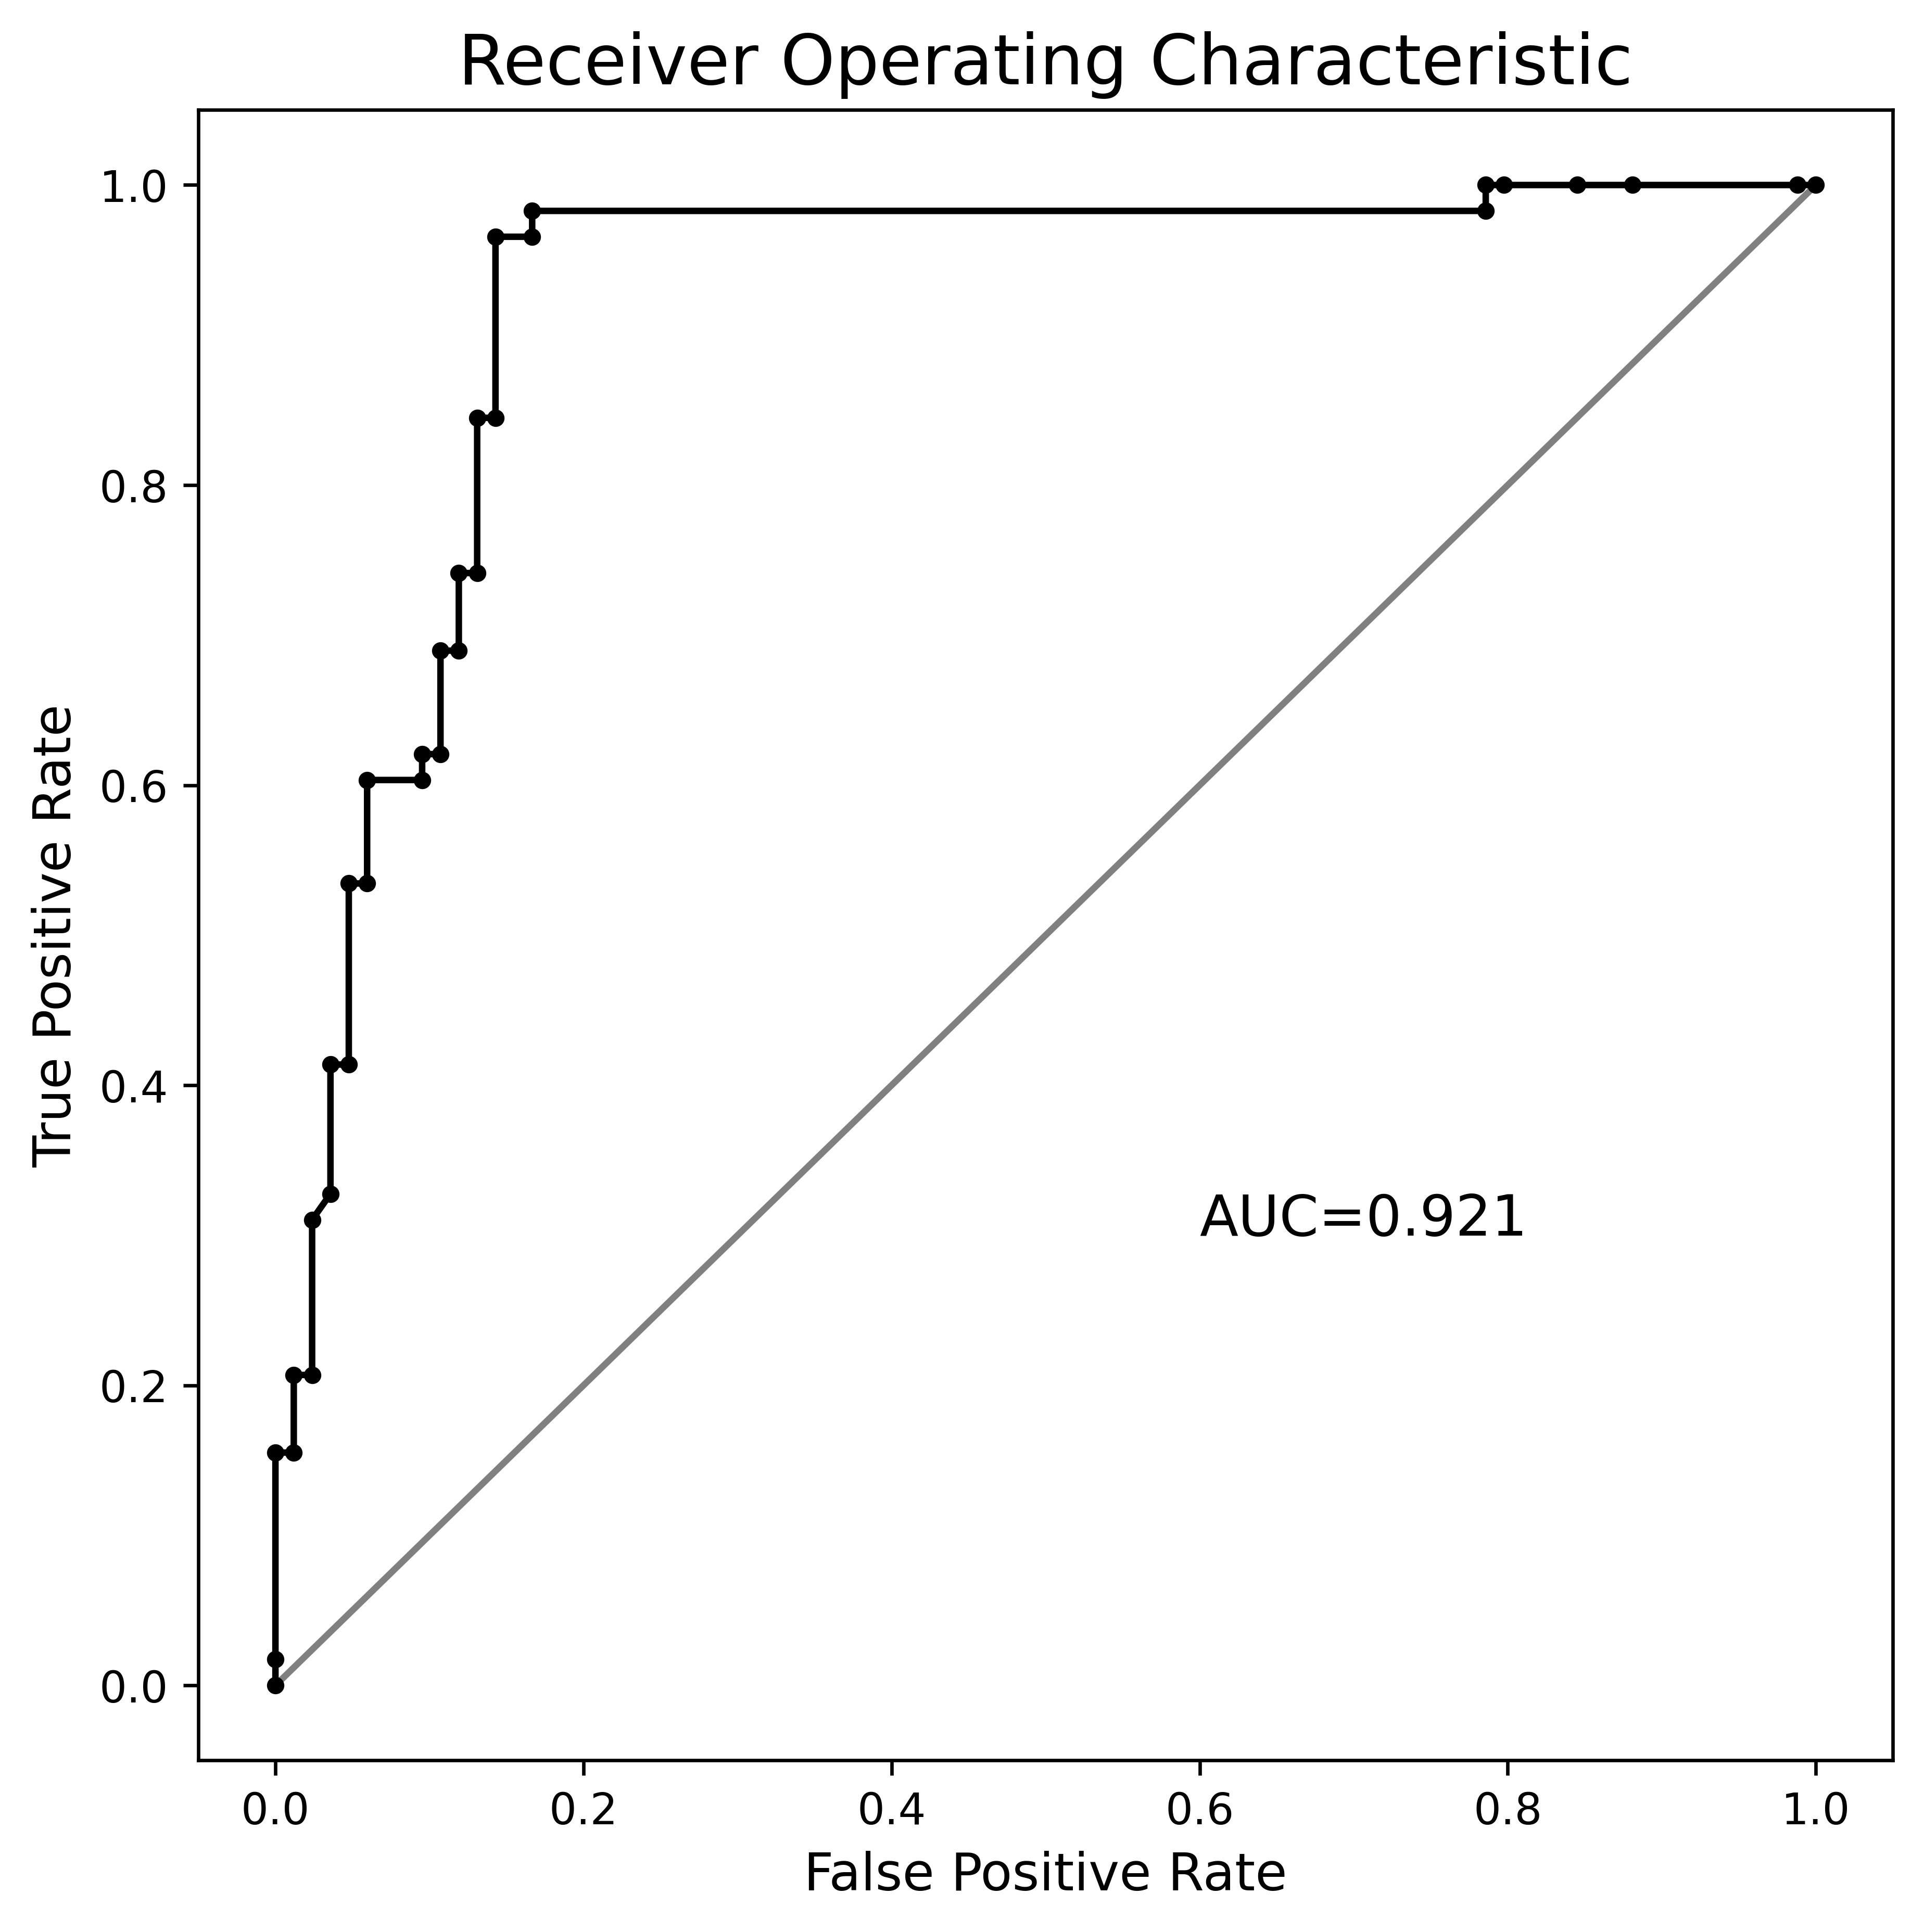

In [365]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_XGBoost_ROC.png', dpi = 600)

In [349]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

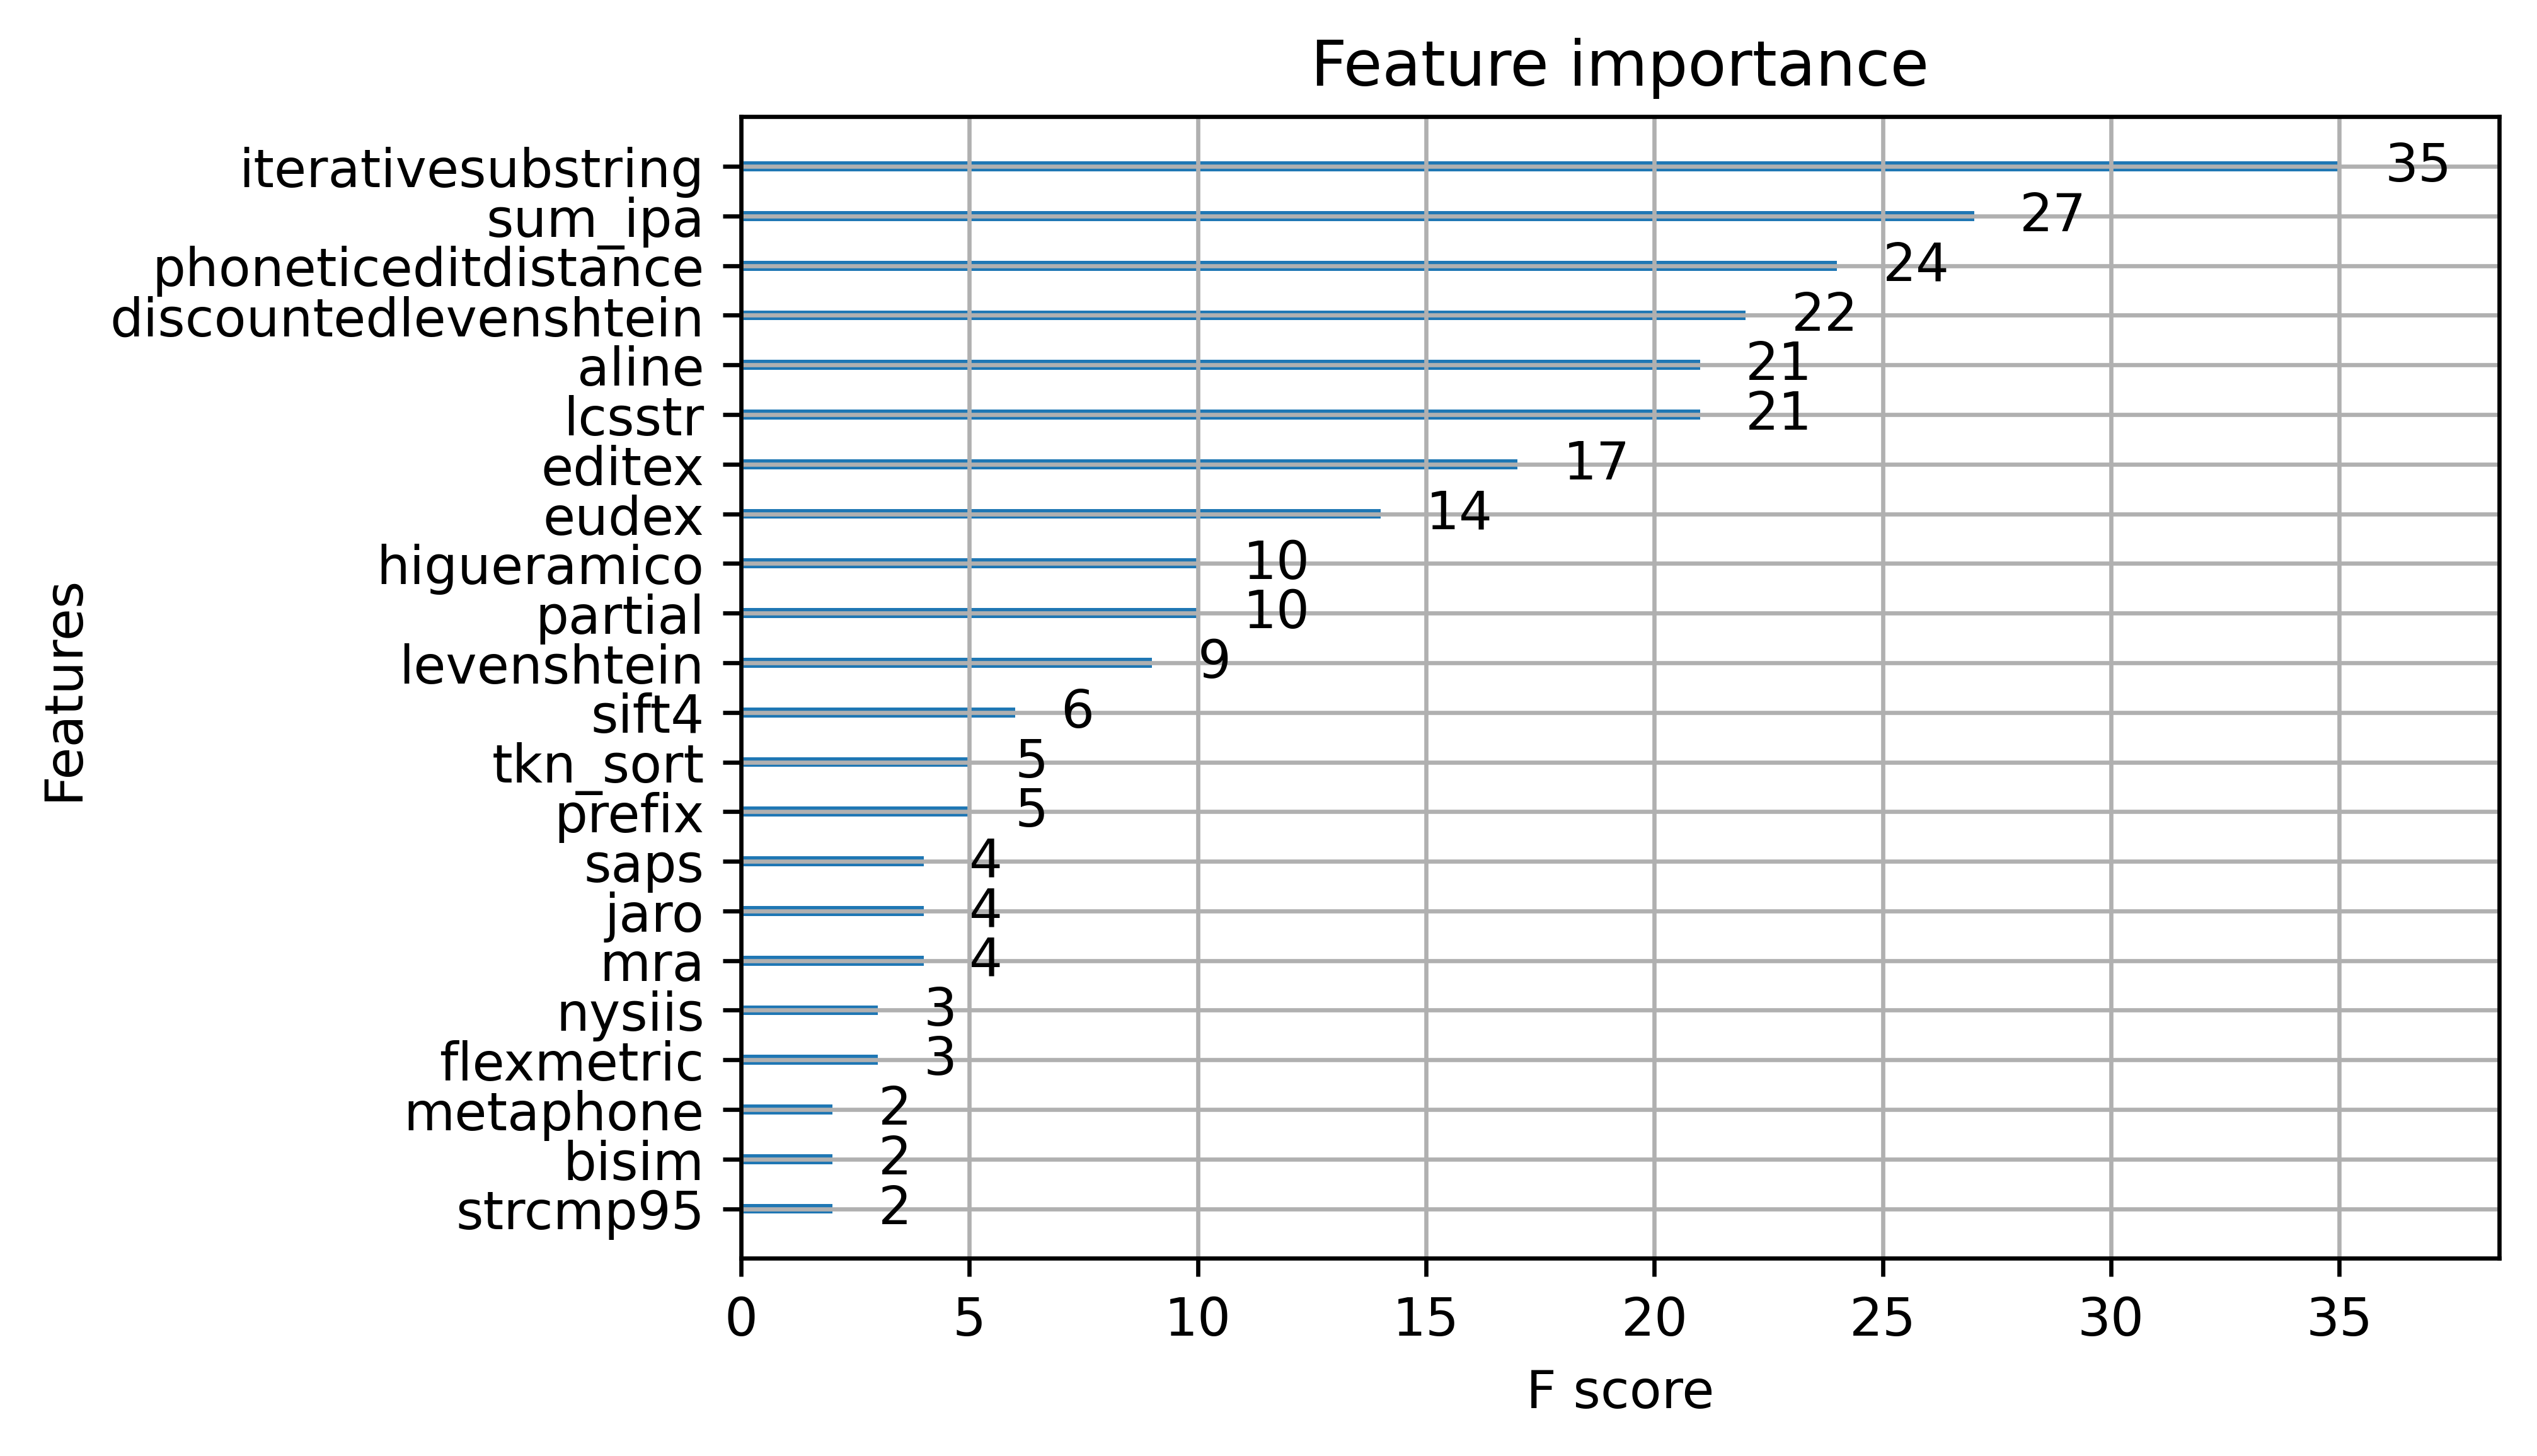

In [364]:
from xgboost import plot_importance
from matplotlib import pyplot

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
# pyplot.show()
# plt.savefig("Figs/TM_XGboost_feature_importance.png", format='png', dpi=600, bbox_inches='tight')

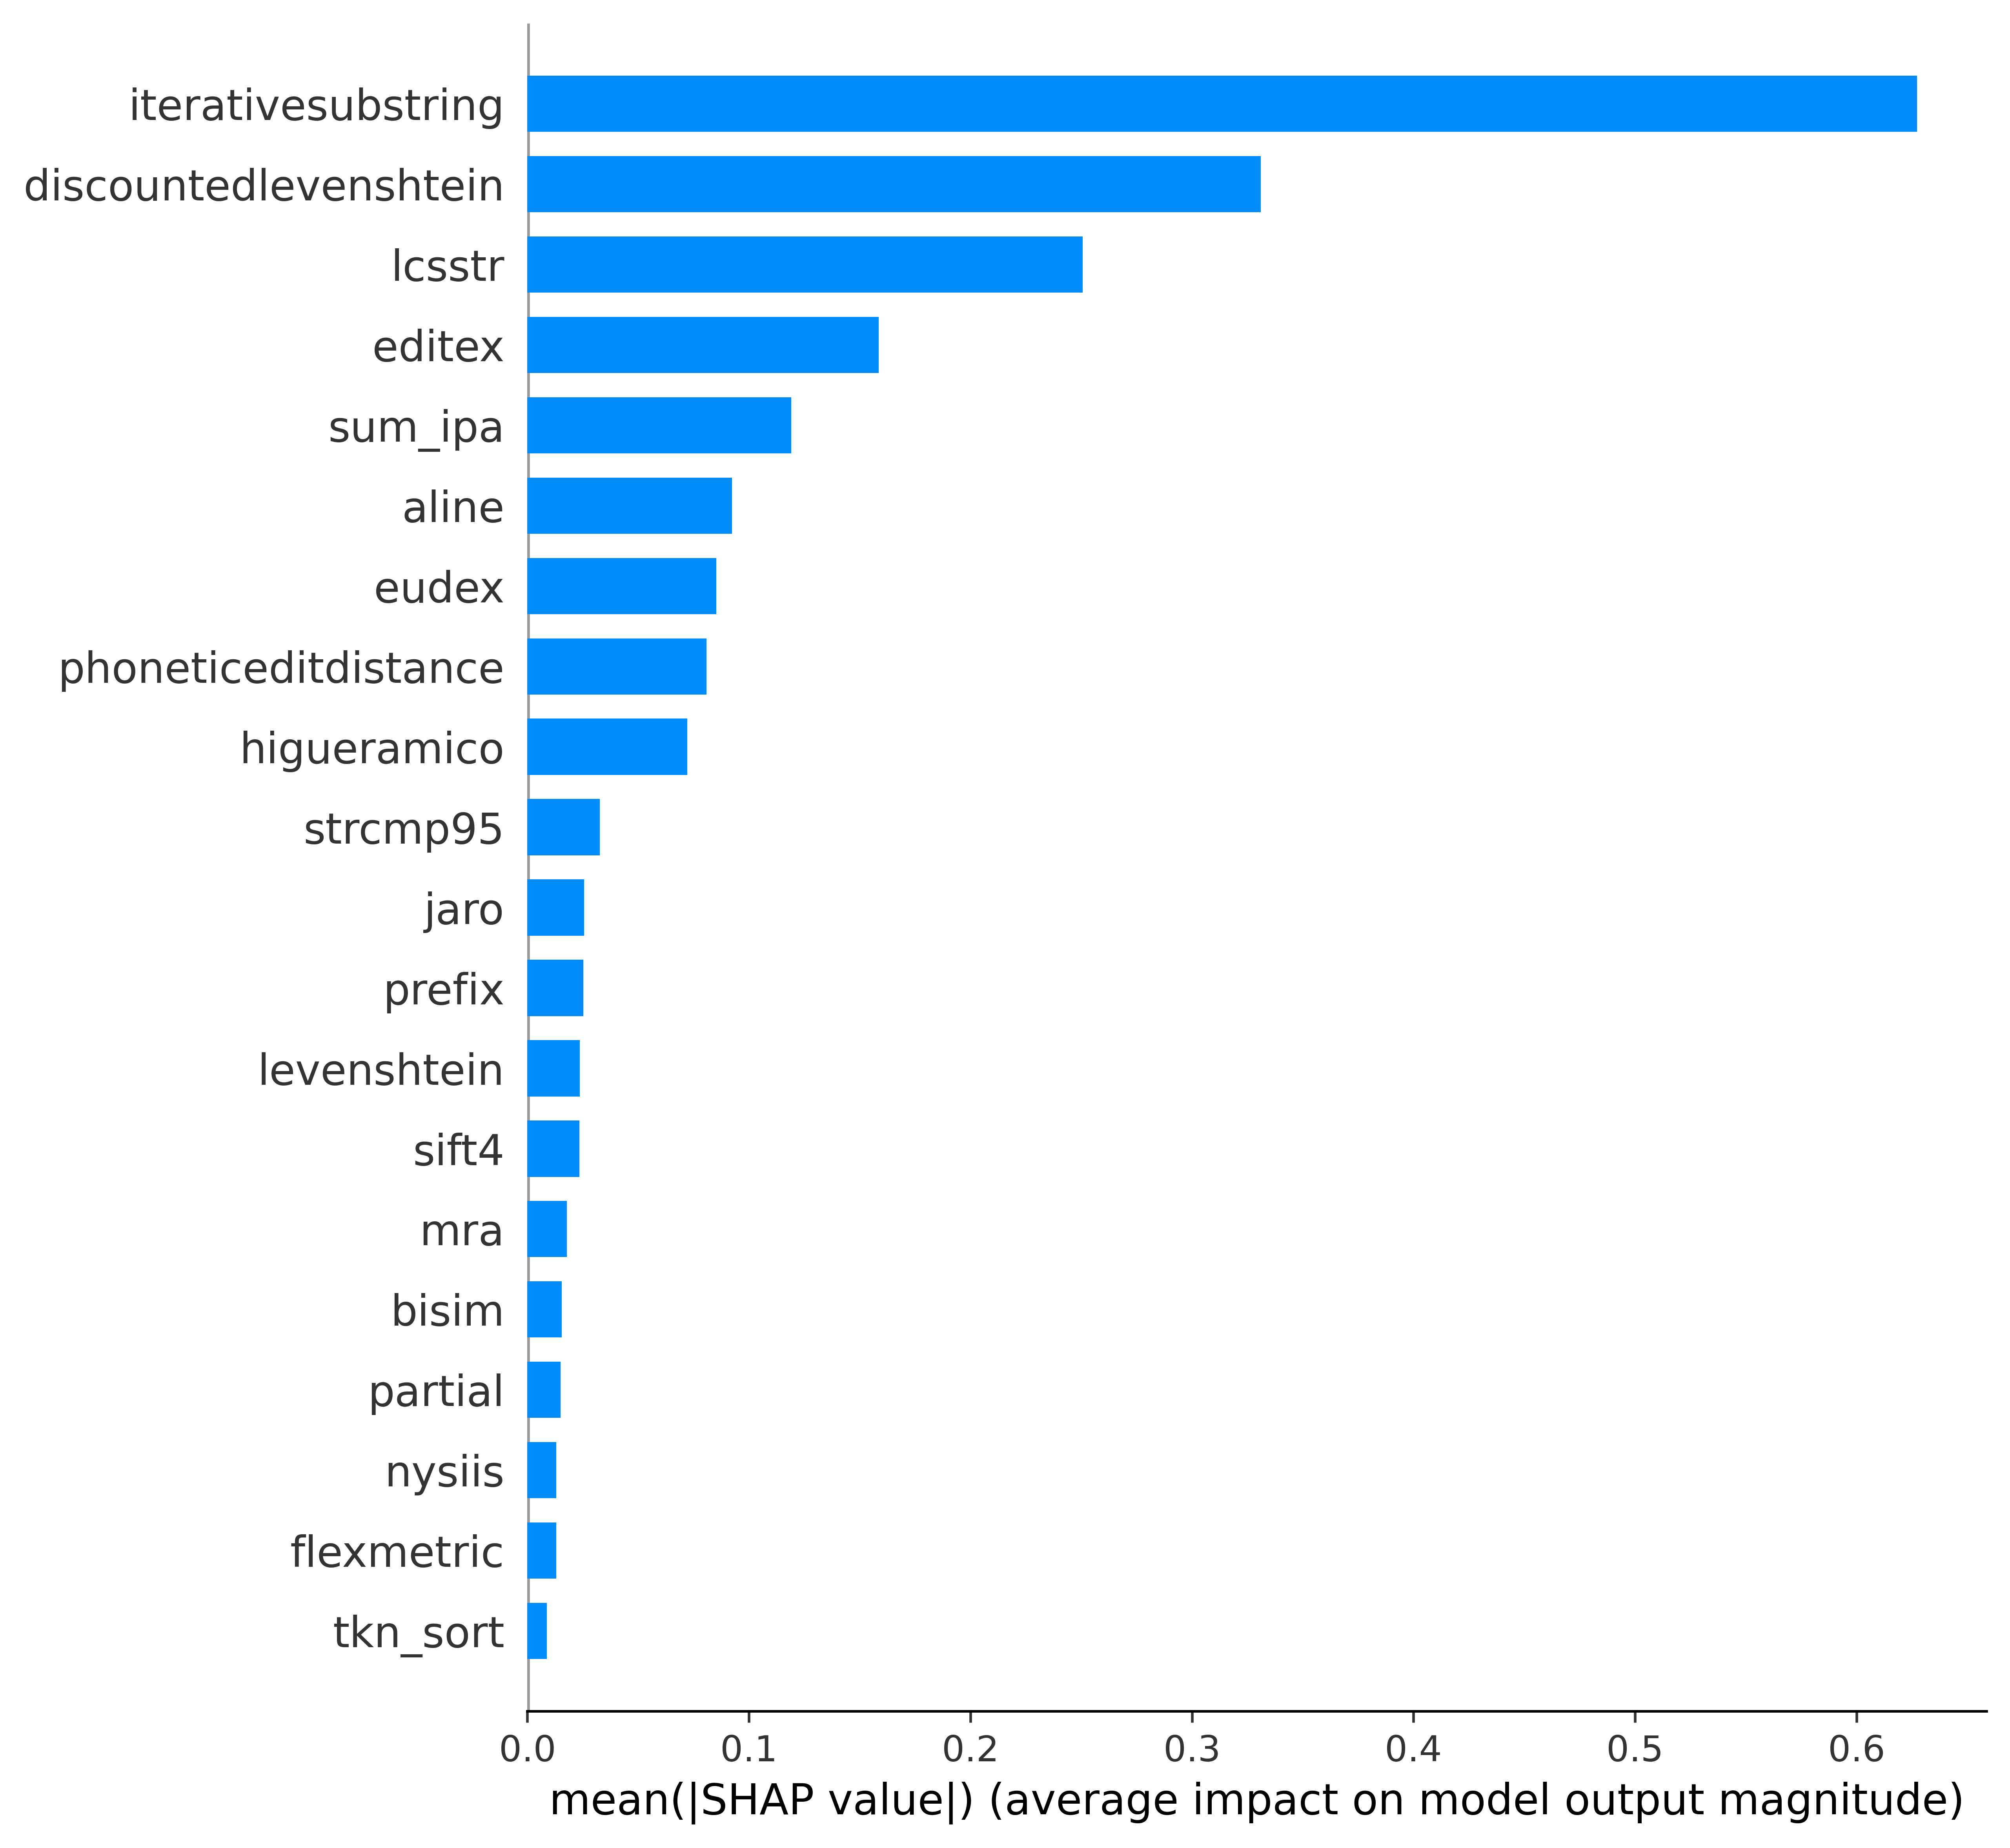

In [363]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar", show=False)
# plt.savefig("Figs/TM_XGboost_SHAP_features.png", format='png', dpi=600, bbox_inches='tight')

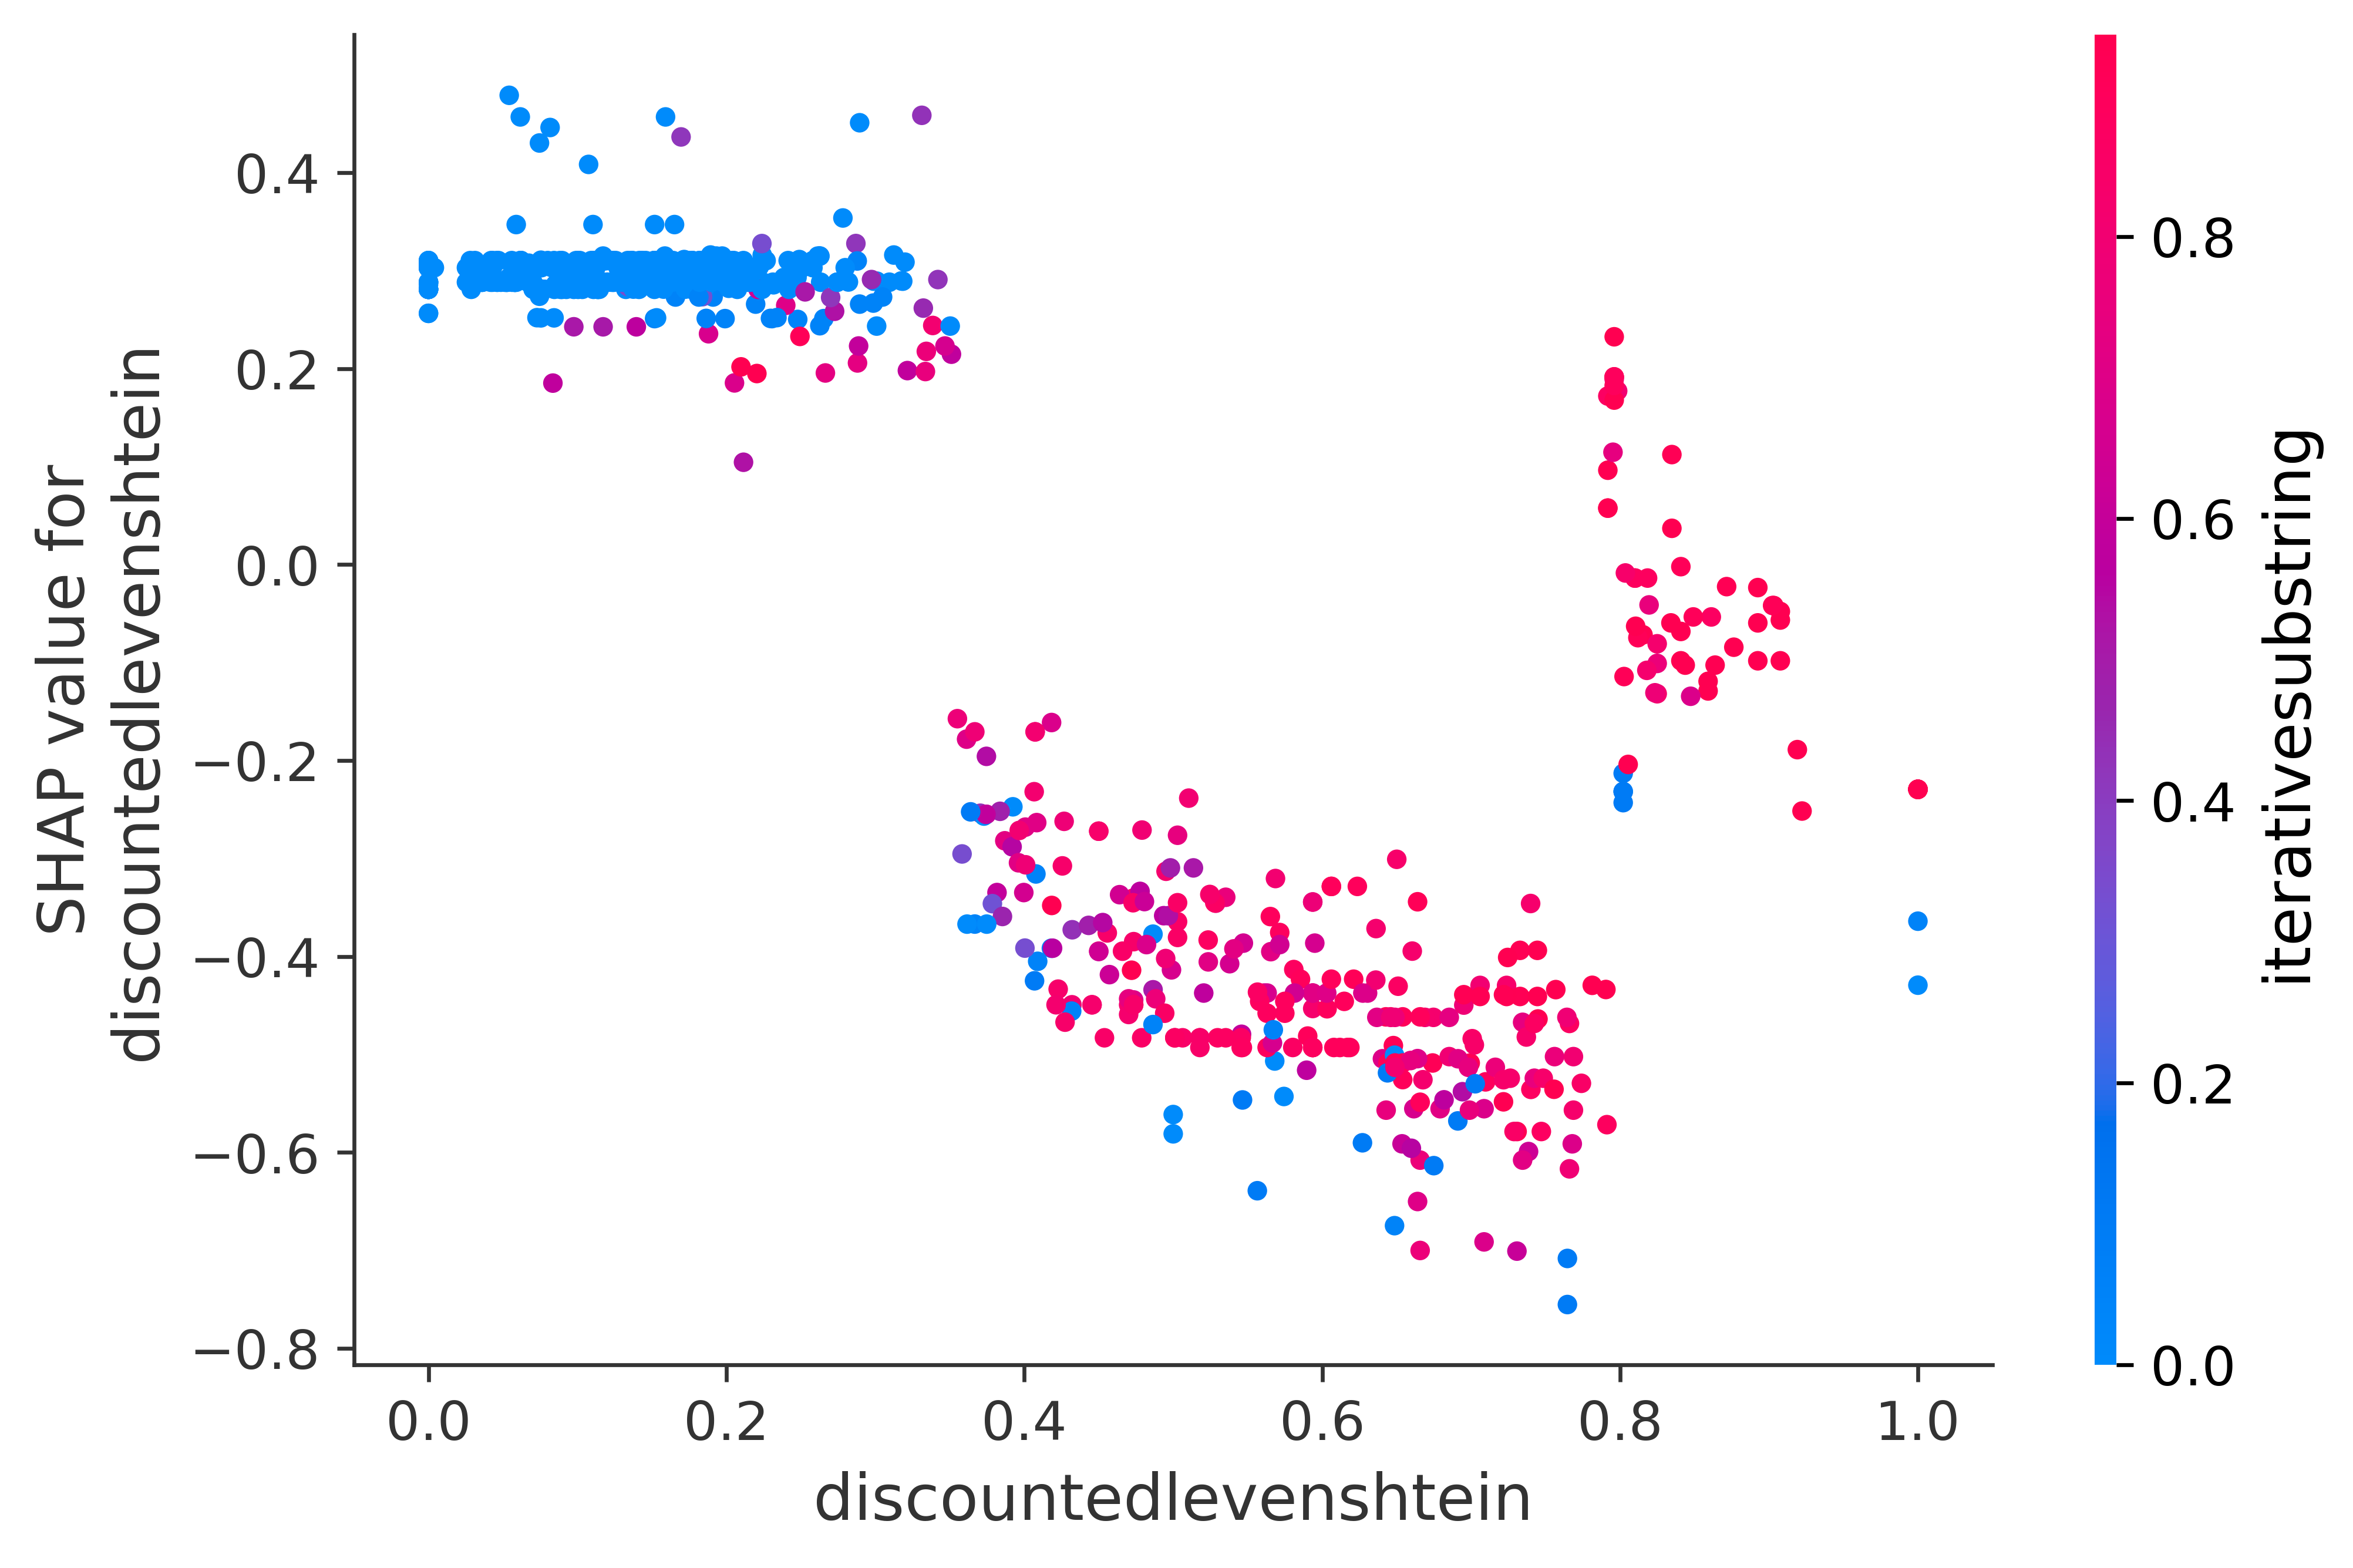

In [352]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


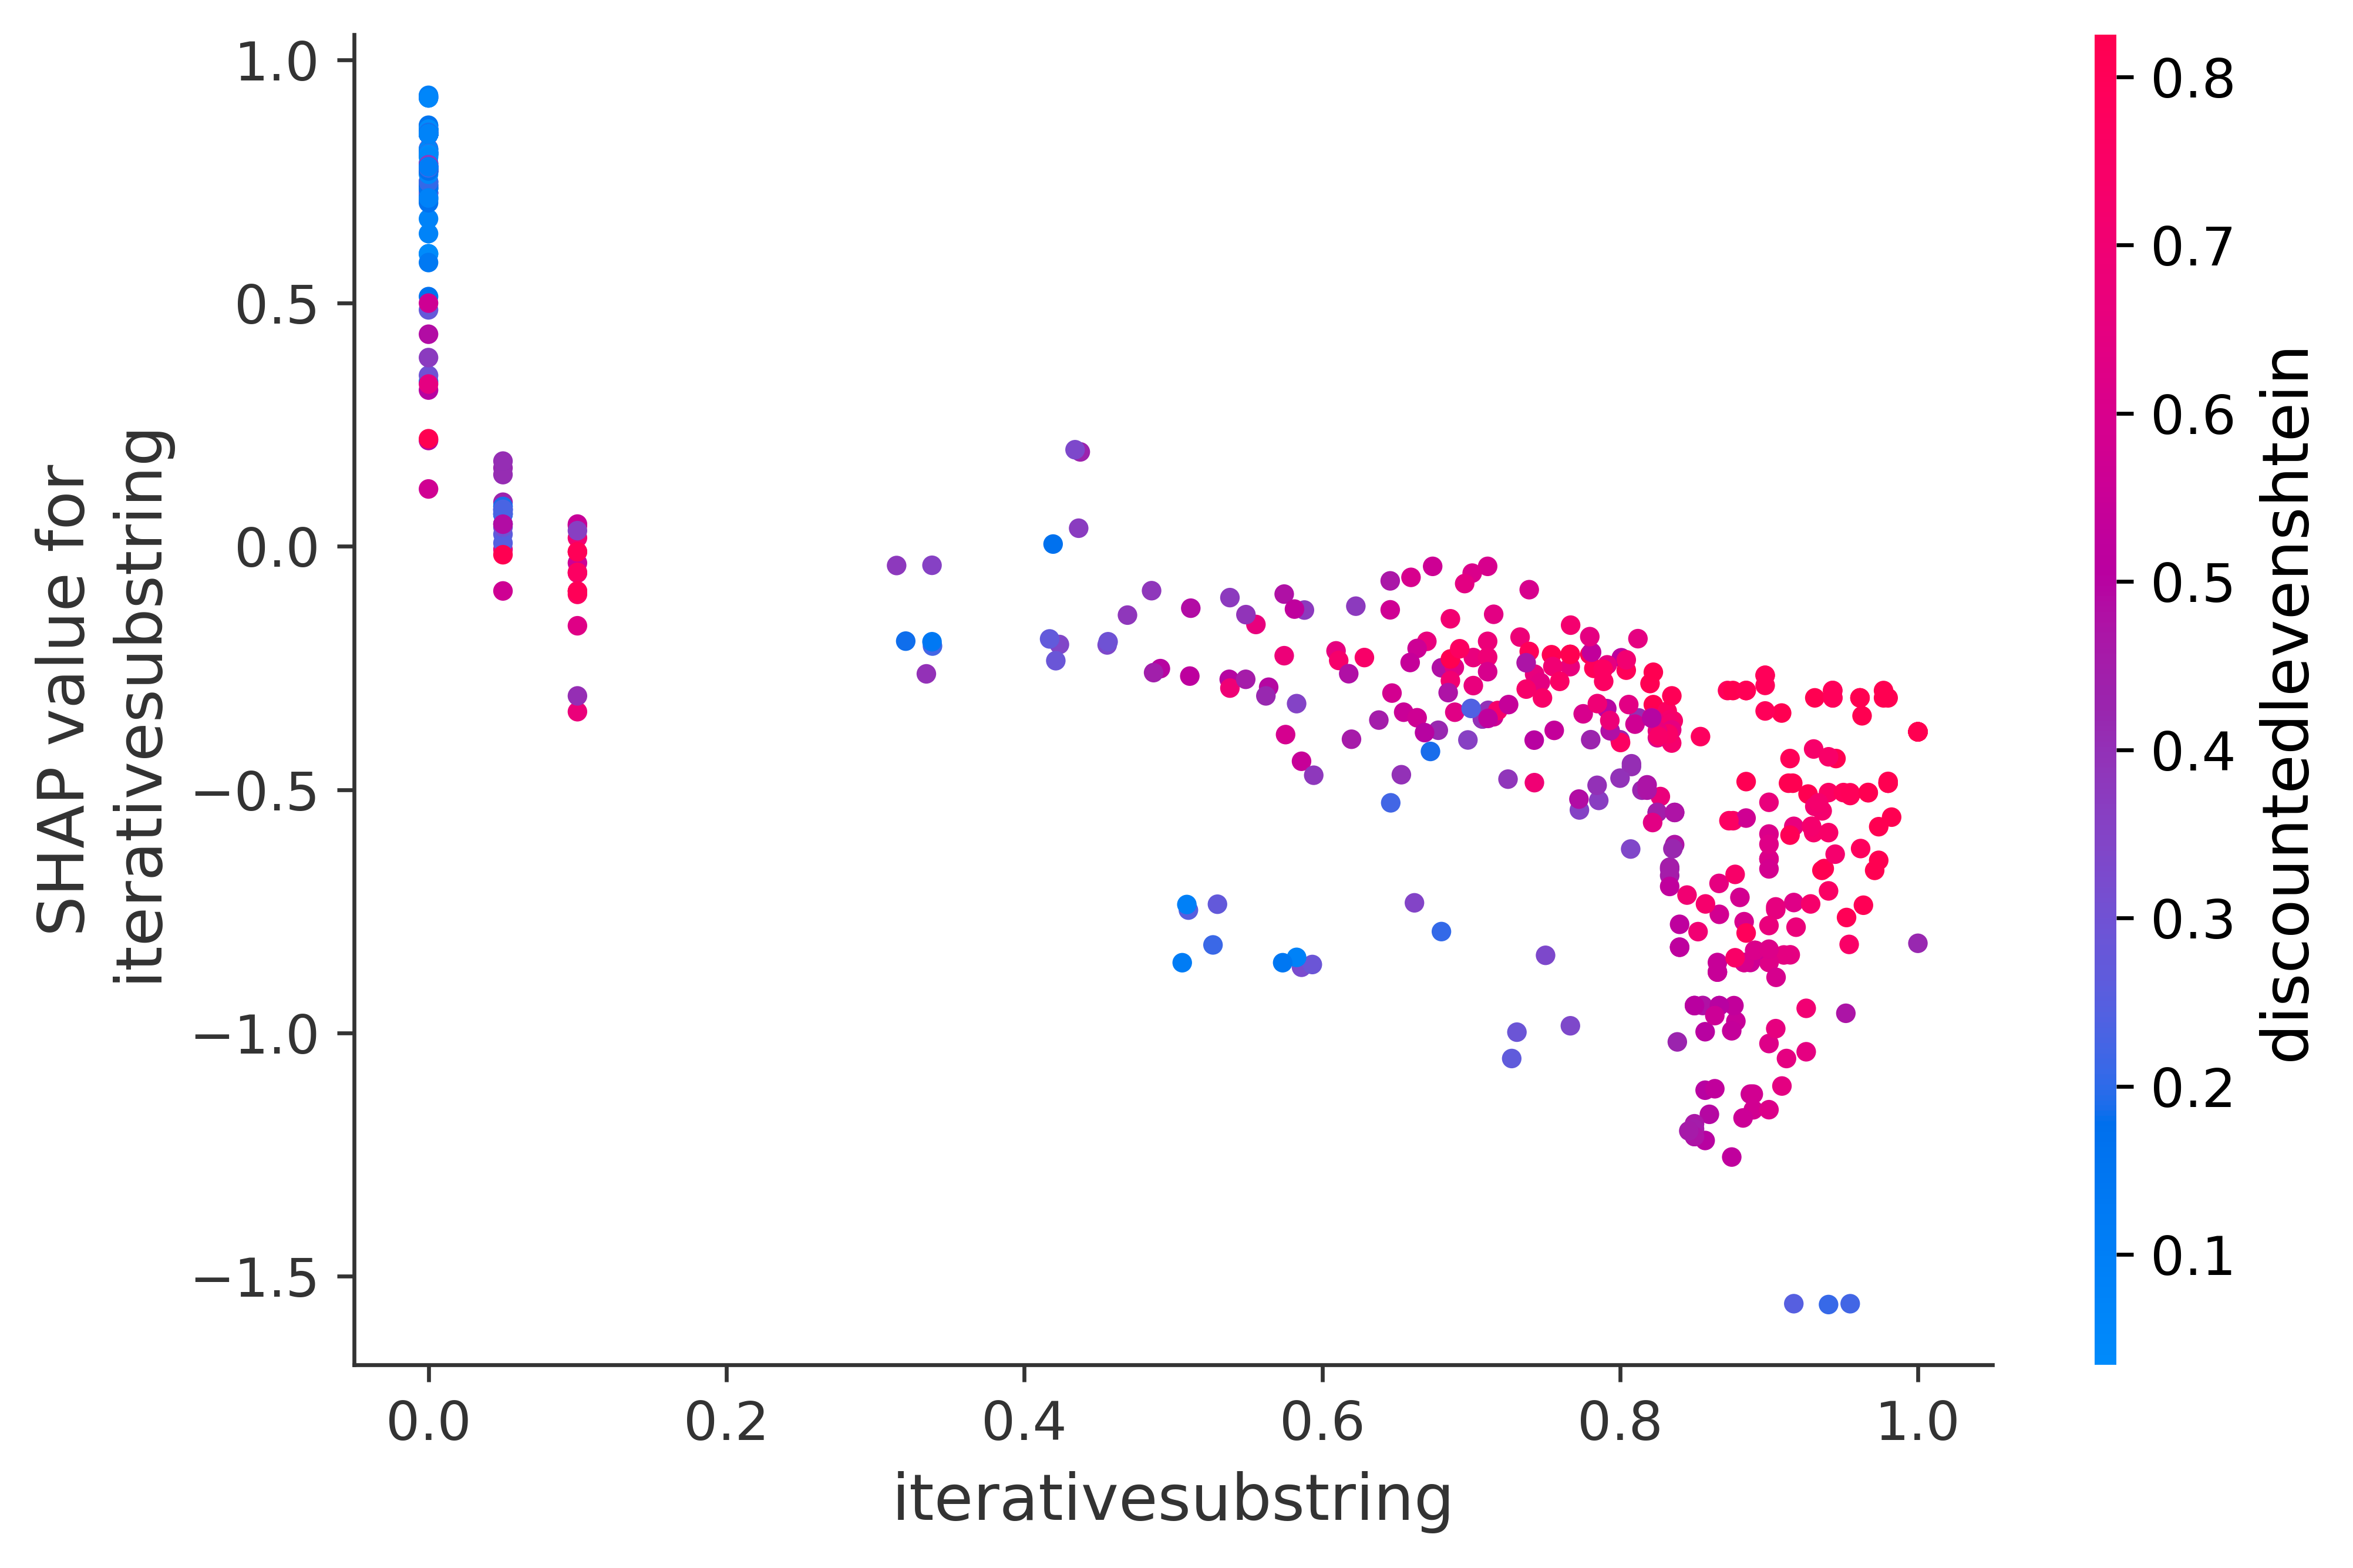

In [353]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


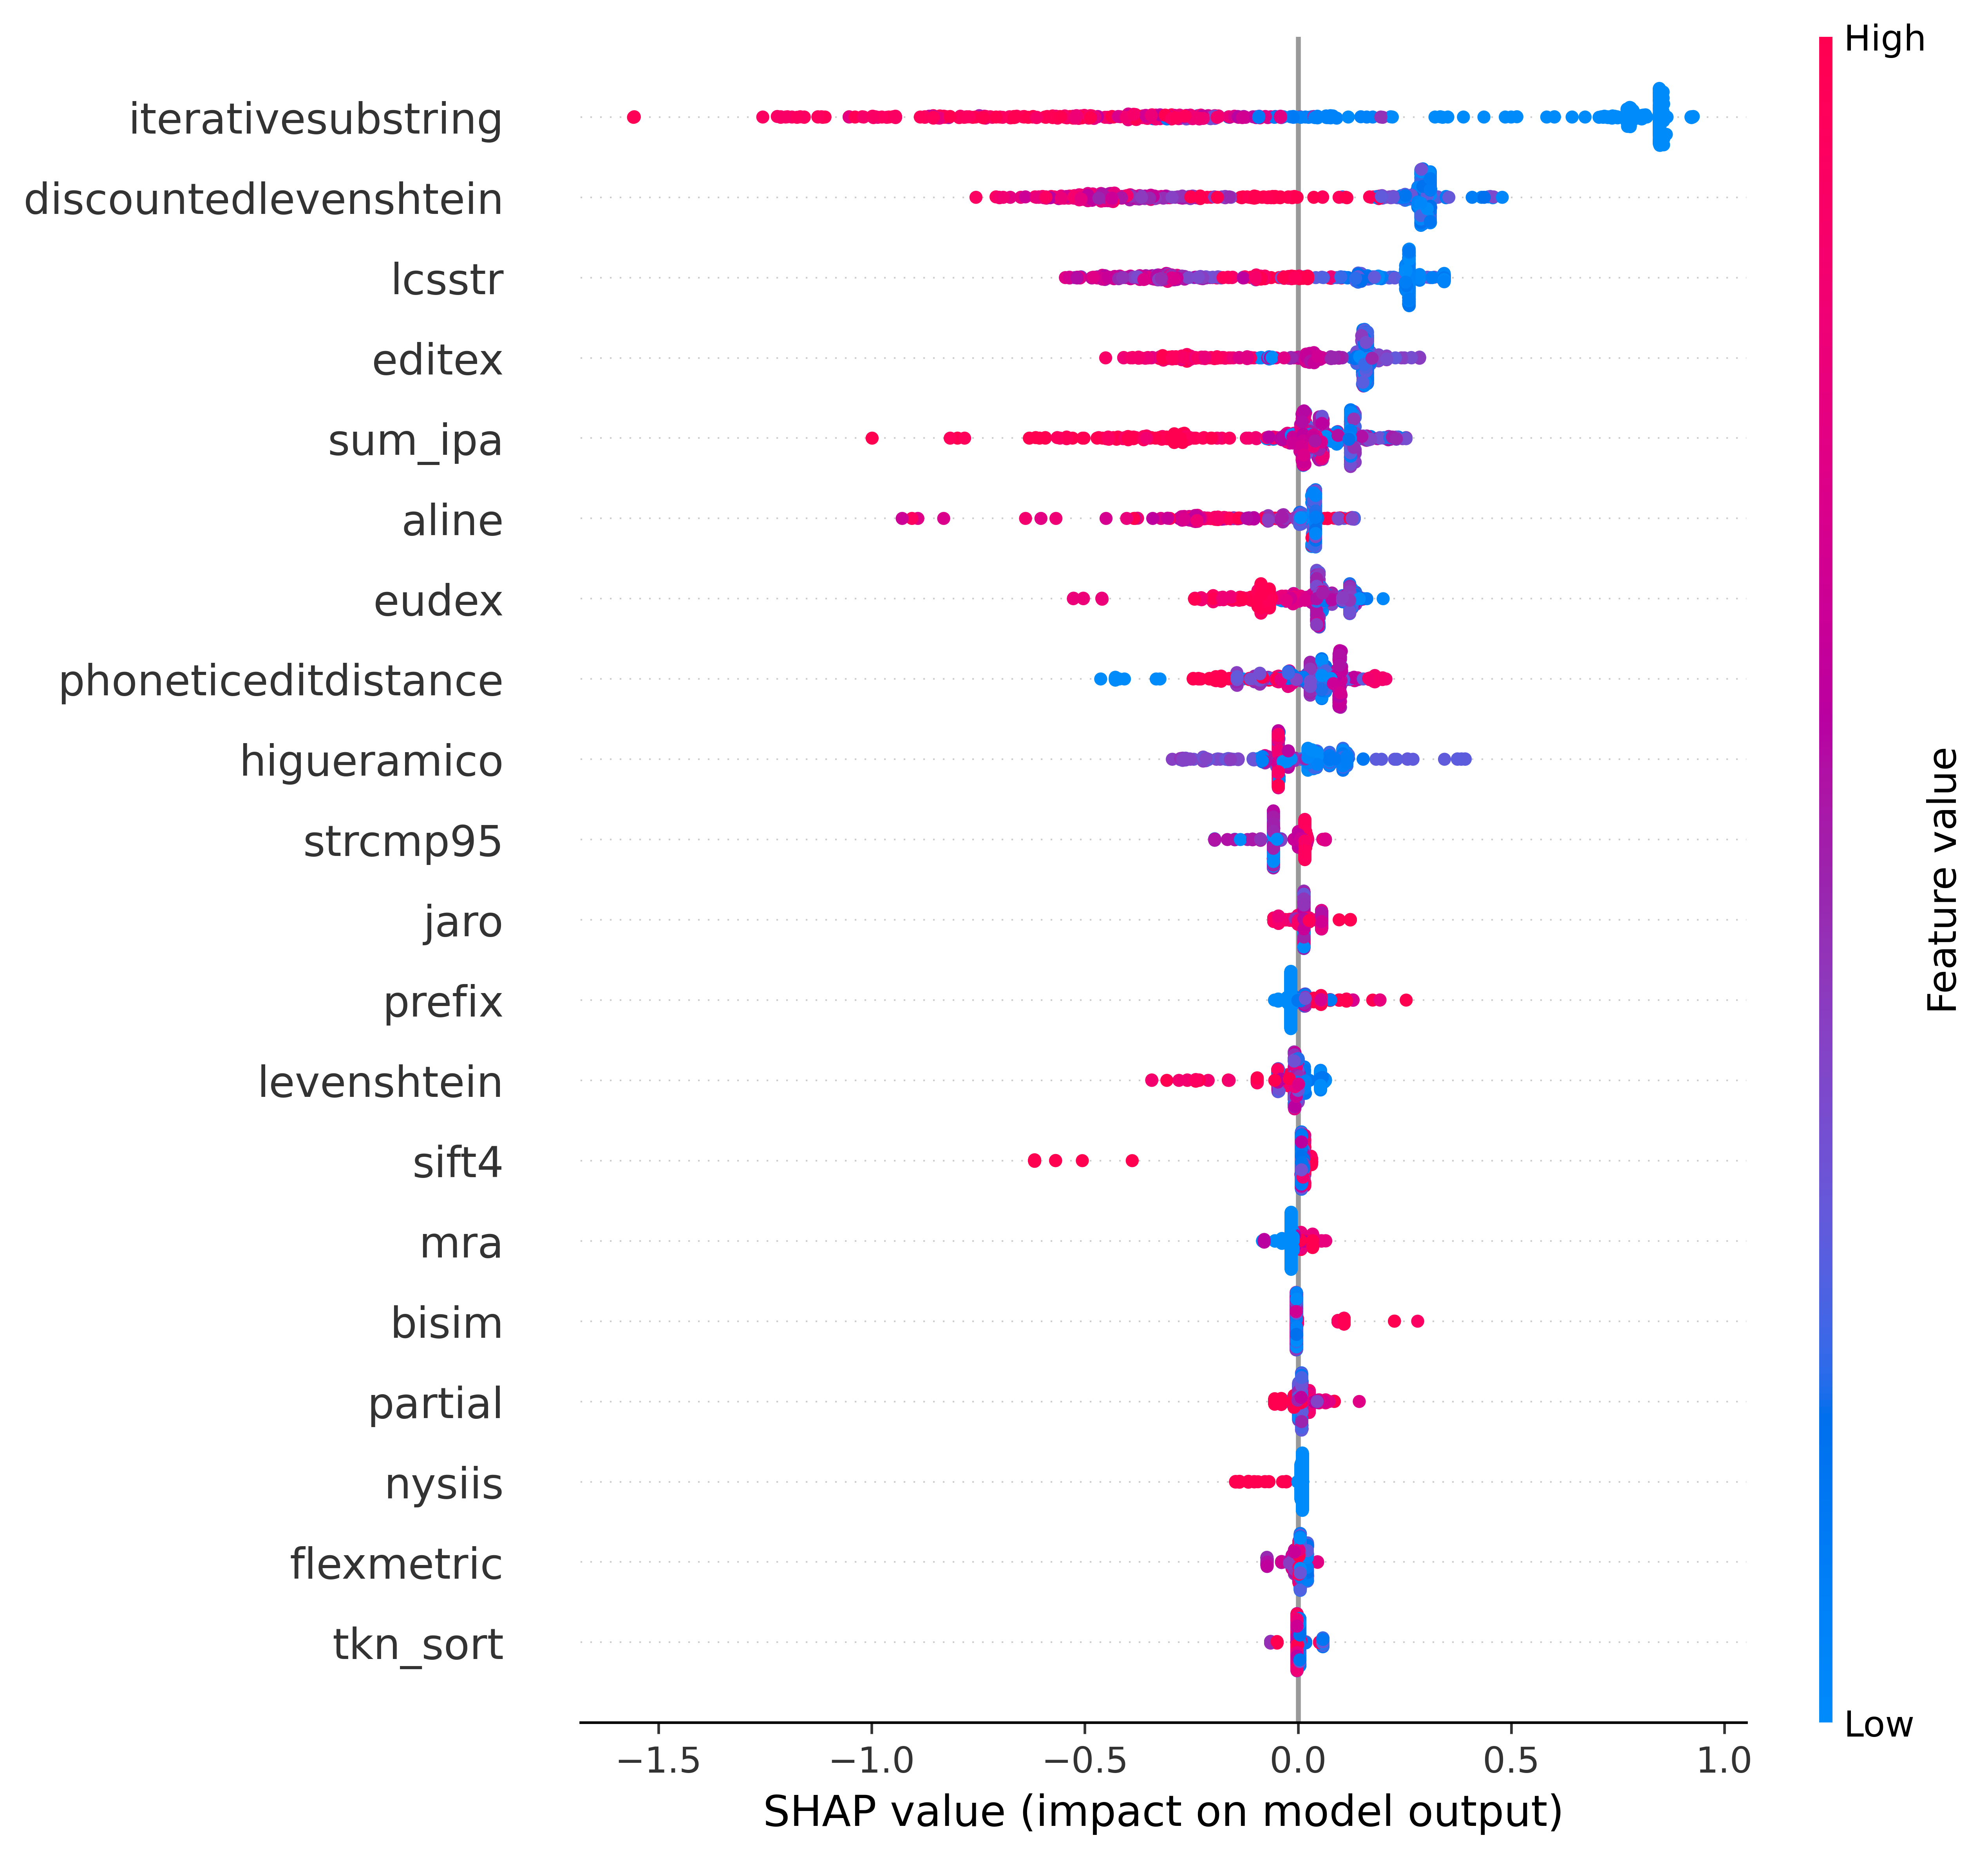

In [354]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['predict_proba', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')

### TPOT AutoML Regression

In [ ]:
from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
        scoring = 'f1', 
        generations=100,
        verbosity=2,
        n_jobs=-1   # Utilizes all available CPU cores
        ) 
pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

exported_pipeline = make_pipeline(